# **Importing Libraries**

In [1]:
import numpy as py
import pandas as pd
import warnings
import requests
import re
import statistics
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from statistics import mode
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from matplotlib.cm import ScalarMappable
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

warnings.filterwarnings('ignore')


# **Creating initial dataframes**

For a comprehensive exploration of the project's dataset, we begin by establishing initial dataframes from various key files. Each file provides distinctive information contributing to a holistic understanding of the movie-related data. The following files serve as the foundation for our project:

1. **`movie_characters_metadata.tsv:`** contains information about each movie character
2. **`movie_conversations.tsv:`** the structure of the conversations
3. **`movie_lines.tsv:`** contains the actual text of each utterance
4. **`movie_titles_metadata.tsv:`** contains information about each movie title
5. **`raw_script_urls.tsv:`** the urls from which the raw sources were retrieved
6. **`title.basics.tsv:`** IMDB data containing details about movies e.g. release year, runtime, genres
7. **`title.crew.tsv:`** IMDB data containing metadata of the crew of a movie (connecting data set with movie and crew IDs)
8. **`name.basics.tsv:`** IMDB data containing details about the crew e,g, name, year, primary profession

General File Features:
- Files are tab seperated ('\t').
- There is no header or footers in any of the files.
- Few bad rows are present in the files. These rows will be dropped while dataframe creation. 

In [2]:
##Creating characters_df dataframe from movie_characters_metadata.tsv

column_names = ['character_id', 'character_name', 'movie_id', 'movie_name', 'character_gender', 'position_credits']
characters_df = pd.read_csv('dataset/movie_characters_metadata.tsv', sep='\t', header=None, names=column_names, on_bad_lines='skip')
print("SUCESS : 'characters_df' dataframe created from 'movie_characters_metadata.tsv'\n")
print('Here is a snapshot of data')
characters_df.head()

SUCESS : 'characters_df' dataframe created from 'movie_characters_metadata.tsv'

Here is a snapshot of data


,character_id,character_name,movie_id,movie_name,character_gender,position_credits
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


In [3]:
##Creating the dataframe : titles_df

column_names = ['movie_id', 'movie_name', 'movie_year', 'movie_rating', 'movie_votes', 'movie_genre']
titles_df = pd.read_csv('dataset/movie_titles_metadata.tsv', sep='\t', names=column_names, header=None, on_bad_lines='skip')
print("SUCESS : 'titles_df' dataframe created from 'movie_titles_metadata.tsv'\n")
print('Here is a snapshot of data')
titles_df.head()

SUCESS : 'titles_df' dataframe created from 'movie_titles_metadata.tsv'

Here is a snapshot of data


,movie_id,movie_name,movie_year,movie_rating,movie_votes,movie_genre
0,m0,10 things i hate about you,1999,6.9,62847.0,['comedy' 'romance']
1,m1,1492: conquest of paradise,1992,6.2,10421.0,['adventure' 'biography' 'drama' 'history']
2,m2,15 minutes,2001,6.1,25854.0,['action' 'crime' 'drama' 'thriller']
3,m3,2001: a space odyssey,1968,8.4,163227.0,['adventure' 'mystery' 'sci-fi']
4,m4,48 hrs.,1982,6.9,22289.0,['action' 'comedy' 'crime' 'drama' 'thriller']


In [4]:
column_names = ['line_id', 'character_id', 'movie_id', 'character_name', 'character_line']
lines_df = pd.read_csv('dataset/movie_lines.tsv', sep='\t', header=None,names=column_names, on_bad_lines='skip')
print("SUCESS : 'lines_df' dataframe created from 'movie_lines.tsv'\n")
print('Here is a snapshot of data')
lines_df.head()

SUCESS : 'lines_df' dataframe created from 'movie_lines.tsv'

Here is a snapshot of data


,line_id,character_id,movie_id,character_name,character_line
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


In [5]:
column_names = ['character_id1', 'character_id2','movie_id', 'line_list']
conversations_df = pd.read_csv('dataset/movie_conversations.tsv', sep='\t',names=column_names, header=None, on_bad_lines='skip')
print("SUCESS : 'conversations_df' dataframe created from 'movie_conversations.tsv'\n")
print('Here is a snapshot of data')
conversations_df.head()

SUCESS : 'conversations_df' dataframe created from 'movie_conversations.tsv'

Here is a snapshot of data


,character_id1,character_id2,movie_id,line_list
0,u0,u2,m0,['L194' 'L195' 'L196' 'L197']
1,u0,u2,m0,['L198' 'L199']
2,u0,u2,m0,['L200' 'L201' 'L202' 'L203']
3,u0,u2,m0,['L204' 'L205' 'L206']
4,u0,u2,m0,['L207' 'L208']


In [6]:
column_names = ['movie_id','movie_name','url']
raw_script_df = pd.read_csv('dataset/raw_script_urls.tsv', sep='\t', names=column_names, header=None, on_bad_lines='skip')
raw_script_df.head()

,movie_id,movie_name,url
0,m0,10 things i hate about you,http://www.dailyscript.com/scripts/10Things.html
1,m1,1492: conquest of paradise,http://www.hundland.org/scripts/1492-ConquestO...
2,m2,15 minutes,http://www.dailyscript.com/scripts/15minutes.html
3,m3,2001: a space odyssey,http://www.scifiscripts.com/scripts/2001.txt
4,m4,48 hrs.,http://www.awesomefilm.com/script/48hours.txt


In [7]:
imdb_movie_title_df = pd.read_csv('dataset/title.basics.tsv.gz', sep='\t', on_bad_lines='skip', compression='gzip')
imdb_movie_title_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [8]:
imdb_movie_crew_df = pd.read_csv('dataset/title.crew.tsv.gz', sep='\t', on_bad_lines='skip', compression='gzip')
imdb_movie_crew_df.head()

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N


In [9]:
imdb_crew_name_df = pd.read_csv('dataset/name.basics.tsv.gz', sep='\t', on_bad_lines='skip', compression='gzip')
imdb_crew_name_df.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0031983,tt0072308,tt0053137,tt0050419"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0038355,tt0117057,tt0037382,tt0075213"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0057345,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0080455,tt0078723,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0069467,tt0083922,tt0050976,tt0050986"


# **Data Cleaning and Pre-processing**

In [10]:
imdb_movie_title_df.titleType.value_counts()

tvEpisode       7903731
short            964221
movie            664400
video            283346
tvSeries         252889
tvMovie          143579
tvMiniSeries      51317
tvSpecial         44549
videoGame         36615
tvShort           10081
tvPilot               1
Name: titleType, dtype: int64

The IMDB dataset contains multiple content types and needs to be filtered for just movies, as the primary dataset only contains movies and if the same named title is present under multiple title types a join on the original dataset will cause duplicates 

In [11]:
imdb_movie_title_df = imdb_movie_title_df[imdb_movie_title_df.titleType == 'movie']

In [12]:
(titles_df['movie_name'].str.upper()).isin(imdb_movie_title_df['primaryTitle'].str.upper()).value_counts()

True     575
False     42
Name: movie_name, dtype: int64

We want to check how many movies from our primary dataset exist in the IMDB data, as we want to obtain director information for each title. Based on the result we have a significant, overlap i.e. 575 of 617 (93.2%) 

First, we'll create a master IMDB dataset by merging on a common key. This will later be used to extract director information and add it to our primary data

In [13]:
imdb_df = imdb_movie_title_df.merge(imdb_movie_crew_df, on='tconst', how='left').merge(imdb_crew_name_df, left_on='directors', right_on='nconst', how='left')

imdb_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,directors,writers,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,nm0085156,nm0085156,nm0085156,Alexander Black,1859,1940,"director,writer,cinematographer",tt0000009
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport",nm0714557,\N,nm0714557,Enoch J. Rector,1863,1957,"director,cinematographer,editor","tt0000147,tt0381108"
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,nm0063413,"nm0063413,nm0657268,nm0675388",nm0063413,Ricardo de Baños,1884,1939,"director,cinematographer,writer","tt0002886,tt0004406,tt0024495,tt0000941"
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",nm0846879,nm0846879,nm0846879,Charles Tait,1868,1933,"director,writer",tt0000574
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,nm0141150,nm0141150,nm0141150,Michel Carré,1865,1945,"director,writer,actor","tt0000591,tt0431913,tt0433554,tt0433594"


In [14]:
titles_df['movie_name_upper'] = titles_df['movie_name'].str.upper()
imdb_df['primaryTitle_upper'] = imdb_df['primaryTitle'].str.upper()


In [15]:
imdb_df.loc[imdb_df['primaryTitle_upper'] == '10 THINGS I HATE ABOUT YOU']

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,directors,writers,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,primaryTitle_upper
95506,tt0147800,movie,10 Things I Hate About You,10 Things I Hate About You,0,1999,\N,97,"Comedy,Drama,Romance",nm0432627,"nm0527581,nm0809006,nm0000636",nm0432627,Gil Junger,\N,\N,"producer,director,miscellaneous","tt0265087,tt5929654,tt0108761,tt0147800",10 THINGS I HATE ABOUT YOU


In [16]:
titles_df.head()

,movie_id,movie_name,movie_year,movie_rating,movie_votes,movie_genre,movie_name_upper
0,m0,10 things i hate about you,1999,6.9,62847.0,['comedy' 'romance'],10 THINGS I HATE ABOUT YOU
1,m1,1492: conquest of paradise,1992,6.2,10421.0,['adventure' 'biography' 'drama' 'history'],1492: CONQUEST OF PARADISE
2,m2,15 minutes,2001,6.1,25854.0,['action' 'crime' 'drama' 'thriller'],15 MINUTES
3,m3,2001: a space odyssey,1968,8.4,163227.0,['adventure' 'mystery' 'sci-fi'],2001: A SPACE ODYSSEY
4,m4,48 hrs.,1982,6.9,22289.0,['action' 'comedy' 'crime' 'drama' 'thriller'],48 HRS.


In [17]:
imdb_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,directors,writers,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,primaryTitle_upper
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,nm0085156,nm0085156,nm0085156,Alexander Black,1859,1940,"director,writer,cinematographer",tt0000009,MISS JERRY
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport",nm0714557,\N,nm0714557,Enoch J. Rector,1863,1957,"director,cinematographer,editor","tt0000147,tt0381108",THE CORBETT-FITZSIMMONS FIGHT
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,nm0063413,"nm0063413,nm0657268,nm0675388",nm0063413,Ricardo de Baños,1884,1939,"director,cinematographer,writer","tt0002886,tt0004406,tt0024495,tt0000941",BOHEMIOS
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",nm0846879,nm0846879,nm0846879,Charles Tait,1868,1933,"director,writer",tt0000574,THE STORY OF THE KELLY GANG
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,nm0141150,nm0141150,nm0141150,Michel Carré,1865,1945,"director,writer,actor","tt0000591,tt0431913,tt0433554,tt0433594",THE PRODIGAL SON


In [18]:
titles_df['movie_name_upper'].isin(imdb_df['primaryTitle_upper']).value_counts()

True     575
False     42
Name: movie_name_upper, dtype: int64

We'll merges `titles_df` and `imdb_df` on movie names and release years, creating `movie_titles_directors_df` with movie details and associated directors. The resulting dataframe displays essential information for the first 20 entries, offering an initial overview of integrated movie and director data.

In [19]:
movie_titles_directors_df = titles_df.merge(imdb_df, left_on=['movie_name_upper', 'movie_year'], right_on=['primaryTitle_upper', 'startYear'], how='left')[['movie_id', 'movie_name', 'movie_year', 'movie_rating', 'movie_genre', 'primaryName']]
movie_titles_directors_df.columns = ['movie_id', 'movie_name', 'movie_year', 'movie_rating', 'movie_genre', 'director_name']
movie_titles_directors_df.head(20)

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_name
0,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger
1,m1,1492: conquest of paradise,1992,6.2,['adventure' 'biography' 'drama' 'history'],Ridley Scott
2,m2,15 minutes,2001,6.1,['action' 'crime' 'drama' 'thriller'],John Herzfeld
3,m3,2001: a space odyssey,1968,8.4,['adventure' 'mystery' 'sci-fi'],Stanley Kubrick
4,m4,48 hrs.,1982,6.9,['action' 'comedy' 'crime' 'drama' 'thriller'],Walter Hill
5,m5,the fifth element,1997,7.5,['action' 'adventure' 'romance' 'sci-fi' 'thri...,Luc Besson
6,m6,8mm,1999,6.3,['crime' 'mystery' 'thriller'],Joel Schumacher
7,m7,a nightmare on elm street 4: the dream master,1988,5.2,['fantasy' 'horror' 'thriller'],Renny Harlin
8,m8,a nightmare on elm street: the dream child,1989,4.7,['fantasy' 'horror' 'thriller'],Stephen Hopkins
9,m9,the atomic submarine,1959,4.9,['sci-fi' 'thriller'],Spencer Gordon Bennet


In [20]:
movie_titles_directors_df.duplicated().value_counts()

False    617
dtype: int64

Initially, set the gender of all directors to Unknown

In [21]:
movie_titles_directors_df['director_gender'] = 'Unknown'
movie_titles_directors_df.head()

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_name,director_gender
0,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,Unknown
1,m1,1492: conquest of paradise,1992,6.2,['adventure' 'biography' 'drama' 'history'],Ridley Scott,Unknown
2,m2,15 minutes,2001,6.1,['action' 'crime' 'drama' 'thriller'],John Herzfeld,Unknown
3,m3,2001: a space odyssey,1968,8.4,['adventure' 'mystery' 'sci-fi'],Stanley Kubrick,Unknown
4,m4,48 hrs.,1982,6.9,['action' 'comedy' 'crime' 'drama' 'thriller'],Walter Hill,Unknown


In [22]:
movie_titles_directors_df['director_name'].fillna('Unknown', inplace=True)

## **Identifying Genders of Movie Directors**

The code below contributes to our project by determining the likely gender of movie directors based on their Wikipedia biographies. The process involves the following steps:

1. **Gender Identification Function:** 
The `identify_gender(text)` function evaluates a given text for the frequency of male and female pronouns and returns the inferred gender ('M', 'F', or 'Unknown').

2. **Web Scraping Wikipedia Biographies:**
The code iterates over entries in the `movie_titles_directors_df` dataframe, constructs Wikipedia URLs for each director, and retrieves the content of associated biographies.
- **Handling Special Cases:** To ensure accurate data retrieval, the code considers scenarios where only one paragraph is present (usually either entry points to disambiguation link or missing) on the Wikipedia page. In such cases, it fetches additional information by modifying the URL to include the director's profession.

3. **Gender Inference Process:**
The paragraphs extracted from Wikipedia are analyzed using the `identify_gender` function, and the inferred genders are collected in a list (dg).

4. **Data Refinement:**
Instances where the gender inference results in 'Unknown' are handled by either removing such instances or assigning 'Unknown' if all results are inconclusive.

5. **Updating Dataframe:**
The inferred genders are then incorporated into the `movie_titles_directors_df` dataframe under the `director_gender` column.



### **Considerations:**
- The code accounts for varying Wikipedia page structures, adapting to different scenarios and ensuring reliable gender identification.
- Special handling of 'Unknown' instances ensures that the final dataset maintains a level of completeness and accuracy.
- The code is designed to scale for the entire dataset, providing a comprehensive gender analysis of movie directors.

In [23]:
def identify_gender(text):
    male_pronouns = ['he', 'him', 'his']
    female_pronouns = ['she', 'her', 'hers']

    words = text.lower().split()

    male_count = len([w for w in words if w in male_pronouns])
    female_count = len([w for w in words if w in female_pronouns])

    if male_count > female_count:
        return 'M'
    elif female_count > male_count:
        return 'F'
    else:
        return 'Unknown'

for index, row in movie_titles_directors_df.iterrows():
	dg=[]
	paragraphs = []
	url = "https://en.wikipedia.org/wiki/" + row['director_name'].replace(" ", "_")
	response = requests.get(url)
	soup = BeautifulSoup(response.content, "html.parser")

	if len(soup.findAll("p")) == 1:
		paragraphs.clear()
		url = "https://en.wikipedia.org/wiki/" + row['director_name'].replace(" ", "_") + "_(director)"
		response = requests.get(url)
		soup = BeautifulSoup(response.content, "html.parser")

	paragraphs = (soup.findAll("p"))

	# print(paragraphs)
	for (i, p) in enumerate(paragraphs):
		if row['director_name'] == "Stephen Hopkins":
			print(identify_gender(p.text))
		dg.append(identify_gender(p.text))

	if 'Unknown' in dg:
		dg = [i for i in dg if i != 'Unknown']

	if len(dg) == 0:
		dg.append('Unknown')

	# print(row['director_name'])
	# print(mode(dg))
	movie_titles_directors_df.loc[index, 'director_gender'] = mode(dg)
	dg.clear()

M
M
M
Unknown
M
M
Unknown
Unknown
M
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
M
M
M
Unknown
M
M
Unknown
Unknown
M
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown
Unknown


In [24]:
movie_titles_directors_df.head(20)

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_name,director_gender
0,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M
1,m1,1492: conquest of paradise,1992,6.2,['adventure' 'biography' 'drama' 'history'],Ridley Scott,M
2,m2,15 minutes,2001,6.1,['action' 'crime' 'drama' 'thriller'],John Herzfeld,M
3,m3,2001: a space odyssey,1968,8.4,['adventure' 'mystery' 'sci-fi'],Stanley Kubrick,M
4,m4,48 hrs.,1982,6.9,['action' 'comedy' 'crime' 'drama' 'thriller'],Walter Hill,M
5,m5,the fifth element,1997,7.5,['action' 'adventure' 'romance' 'sci-fi' 'thri...,Luc Besson,M
6,m6,8mm,1999,6.3,['crime' 'mystery' 'thriller'],Joel Schumacher,M
7,m7,a nightmare on elm street 4: the dream master,1988,5.2,['fantasy' 'horror' 'thriller'],Renny Harlin,M
8,m8,a nightmare on elm street: the dream child,1989,4.7,['fantasy' 'horror' 'thriller'],Stephen Hopkins,M
9,m9,the atomic submarine,1959,4.9,['sci-fi' 'thriller'],Spencer Gordon Bennet,M


In [25]:
movie_titles_directors_df.director_gender.value_counts()

M          484
Unknown    117
F           16
Name: director_gender, dtype: int64

The outcome of the gender identification process sheds light on the gender distribution among movie directors in the `movie_titles_directors_df` dataframe.

### **Insights**
- The dataset prominently features male directors, with `484` instances identified as such. This dominance is reflective of broader industry trends.
- The dataset includes a relatively smaller count of `16` identified as female directors, indicating a potential gender disparity in the industry.
- A notable number of directors (`117`) have 'Unknown' gender classifications, highlighting challenges in accurately determining gender based on available information.
- Exploring correlations between gender and other factors such as movie genres, ratings, or release years could provide deeper insights into industry dynamics.


We merge `movie_titles_directors_df` with `characters_df` and `lines_df`, creating a comprehensive `final_df` that integrates movie details, director information, character attributes, and corresponding lines. Duplicates and unnecessary columns are removed, and the resulting dataframe is structured with meaningful column names for clarity and insight, ready to be aused for analysis

In [26]:
final_df = movie_titles_directors_df.merge(characters_df, on='movie_id', how='left').merge(lines_df, on=['movie_id', 'character_id'], how='left')
final_df.drop(['movie_name_y', 'character_name_y'], axis=1, inplace=True)
final_df.columns=['movie_id', 'movie_name', 'movie_year',	'movie_rating',	'movie_genre','director_name'	,'director_gender'	,'character_id',	'character_name',	'character_gender',	'position_credits',	'line_id',	'character_line']
final_df.head(20)

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_name,director_gender,character_id,character_name,character_gender,position_credits,line_id,character_line
0,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,f,4,L1045,They do not!
1,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,f,4,L985,I hope so.
2,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,f,4,L925,Let's go.
3,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,f,4,L872,Okay -- you're gonna need to learn how to lie.
4,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,f,4,L869,Like my fear of wearing pastels?
5,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,f,4,L867,What good stuff?
6,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,f,4,L864,Me. This endless ...blonde babble. I'm like b...
7,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,f,4,L862,do you listen to this crap?
8,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,f,4,L698,But
9,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,f,4,L696,Well no...


In [27]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288716 entries, 0 to 288715
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   movie_id          288716 non-null  object 
 1   movie_name        288715 non-null  object 
 2   movie_year        288715 non-null  object 
 3   movie_rating      288715 non-null  float64
 4   movie_genre       288715 non-null  object 
 5   director_name     288716 non-null  object 
 6   director_gender   288716 non-null  object 
 7   character_id      288715 non-null  object 
 8   character_name    288672 non-null  object 
 9   character_gender  288715 non-null  object 
 10  position_credits  288715 non-null  object 
 11  line_id           288447 non-null  object 
 12  character_line    288193 non-null  object 
dtypes: float64(1), object(12)
memory usage: 30.8+ MB


In [28]:
print("Distribution Of NaN across dataframe")
nan_percentage = (final_df.isna().mean() * 100).round(5)
print(nan_percentage)

Distribution Of NaN across dataframe
movie_id            0.00000
movie_name          0.00035
movie_year          0.00035
movie_rating        0.00035
movie_genre         0.00035
director_name       0.00000
director_gender     0.00000
character_id        0.00035
character_name      0.01524
character_gender    0.00035
position_credits    0.00035
line_id             0.09317
character_line      0.18115
dtype: float64


In [29]:
num_rows_dropped = final_df.isna().any(axis=1).sum()
print("Number of rows that would be dropped due to NaN:", num_rows_dropped)

Number of rows that would be dropped due to NaN: 566


In [30]:
# Removing rows with NaN values
final_df = final_df.dropna()

In [31]:
# Remove duplicate rows
duplicate_counts = final_df.duplicated().sum()
print("Total duplicate", duplicate_counts)
if duplicate_counts > 0:
  characters_df = final_df.drop_duplicates()

Total duplicate 0


### **Cleaning the Movie Year Column**

The column `movie_year` contains information on the year of the movie release. The year information cannot be non-numeric and it has to be in `YYYY` format.

As shown below, some of the rows contain year appended with a string. As part of preprocessing, the year part is extracted from the string.


In [32]:
column_name = 'movie_year'

# Filter non-numeric values in the specified column
non_numeric_values = final_df.loc[~pd.to_numeric(final_df[column_name], errors='coerce').notna(), column_name]

# Get unique non-numeric values
unique_non_numeric_values = non_numeric_values.unique()

# Display the unique non-numeric values
print("Unique non-numeric values in column '{}':".format(column_name))
print(unique_non_numeric_values)

Unique non-numeric values in column 'movie_year':
['1989/I' '1990/I' '1995/I' '1998/I' '2004/I' '2007/I' '1992/I' '2005/I'
 '2002/I' '1968/I' '1996/I' '2000/I' '2009/I' '2003/I']


In [33]:
column_name = 'movie_year'

# Extract numeric portion using regular expression
final_df[column_name] = final_df[column_name].str.extract('(\d+)', expand=False)
final_df[column_name] = final_df[column_name].astype(int)

In [34]:
final_df.movie_year.unique()

array([1999, 1992, 2001, 1968, 1982, 1997, 1988, 1989, 1959, 1980, 1986,
       1984, 1981, 1932, 2000, 1998, 1991, 1975, 2003, 2006, 1996, 2004,
       1995, 1942, 1974, 1990, 1933, 1993, 2005, 1931, 2009, 2002, 1967,
       1971, 1979, 1987, 1940, 1961, 2007, 1953, 1934, 1983, 1994, 1985,
       1976, 1937, 1955, 1970, 1941, 1927, 1939, 1936, 1954, 1949, 1943,
       2010, 1977, 1972, 1963, 1945, 2008, 1960, 1964, 1950, 1973, 1966,
       1944, 1978, 1946, 1969, 1965, 1957, 1958])

### **Removing Ambiguity From The Gender Column**

In this project we are dividing gender to two groups "Male" (M) & "Female" (F). 

However during the initial data analysis, it is identified that 5 different types of values are available in the column gender('?', 'm', 'f', 'M', 'F'). On further investigation, it has been confirmed all gender where data is 'm' & 'M' belong to male(M) class and similarly 'f' & 'F' can be grouped as female(F). 

The rows with '?' as gender must be dropped as `character_id` is the identifier column for the dataframe and there is no `character_id` with multiple gender so there is no scope for data correction.

In this dataframe 'Male' class will be represented as 'M' & 'Female' class will be represented as 'F'.

In [35]:
##Count of values of each gender type
final_df.character_gender.value_counts()

m    145845
f     63284
?     59044
M     15399
F      4578
Name: character_gender, dtype: int64

In [36]:
##Data Analysis to check if any chId has multiple gender assigned to it.
##Result: None found
grouped = final_df.groupby('character_id')['character_gender'].nunique()
characters_with_multiple_genders = grouped[grouped > 1].index.tolist()
print("characters with more than one gender:", len(characters_with_multiple_genders))

characters with more than one gender: 0


In [37]:
##Removing data ambiguity from gender
final_df = final_df[final_df.character_gender != '?']
final_df.character_gender = final_df.character_gender.apply(lambda g: 'M' if g in ['m', 'M'] else 'F')
print("Data Distribution Per Gender:")
final_df.groupby('character_gender')['character_id'].nunique()

Data Distribution Per Gender:


character_gender
F     948
M    2003
Name: character_id, dtype: int64

In [38]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229106 entries, 0 to 288617
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   movie_id          229106 non-null  object 
 1   movie_name        229106 non-null  object 
 2   movie_year        229106 non-null  int32  
 3   movie_rating      229106 non-null  float64
 4   movie_genre       229106 non-null  object 
 5   director_name     229106 non-null  object 
 6   director_gender   229106 non-null  object 
 7   character_id      229106 non-null  object 
 8   character_name    229106 non-null  object 
 9   character_gender  229106 non-null  object 
 10  position_credits  229106 non-null  object 
 11  line_id           229106 non-null  object 
 12  character_line    229106 non-null  object 
dtypes: float64(1), int32(1), object(11)
memory usage: 23.6+ MB


## **Removing non-numeric values from the column position_credits**

As per the column defination, `position_credits` is  numeric column containing the information of the position where the character features in the credits. Hence this cannot be non-numeric. 

Since a significant number of rows (`330`) contain `'?'` we will replace it with `-1`. This would indicate the character did not appear in the posCredit.

In [39]:
non_numeric_position_credits = final_df.loc[~pd.to_numeric(final_df['position_credits'], errors='coerce').notna(), 'position_credits'].unique()
print("Non-numeric values in 'position_credits' column:", non_numeric_position_credits)


#Examine the distribution of male & female with this junk data
filtered_df = final_df[final_df['position_credits'] == '?']
# Count the number of males and females
male_count = filtered_df[filtered_df['character_gender'] == 'M']
female_count = filtered_df[filtered_df['character_gender'] == 'F']

print("Number of males with position_credits = '?':", male_count.groupby('character_gender')['character_id'].nunique())
print("Number of females with position_credits = '?':", female_count.groupby('character_gender')['character_id'].nunique())

Non-numeric values in 'position_credits' column: ['?']
Number of males with position_credits = '?': character_gender
M    222
Name: character_id, dtype: int64
Number of females with position_credits = '?': character_gender
F    102
Name: character_id, dtype: int64


In [40]:
final_df['position_credits'] = final_df['position_credits'].replace('?', -1).astype(int)
final_df.describe()

,movie_year,movie_rating,position_credits
count,229106.000000,229106.000000,229106.000000
mean,1987.891264,6.992279,9.579243
std,17.314424,1.146805,79.434358
min,1927.000000,2.500000,-1.000000
25%,1984.000000,6.400000,1.000000
50%,1995.000000,7.200000,2.000000
75%,1999.000000,7.800000,4.000000
max,2010.000000,9.300000,1000.000000


In [41]:
##Get the number of unique dialogues spoken by each characters.
final_df['character_dialog_count'] = final_df.groupby(['character_id', 'movie_id'])['character_line'].transform('count')

##Get the number of words per dialogue
final_df['dialog_word_count'] = final_df.character_line.str.count(' ') + 1

##Get number of character in the dialog
final_df['dialog_length'] = final_df.character_line.str.len()

In [42]:
final_df.head()

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_name,director_gender,character_id,character_name,character_gender,position_credits,line_id,character_line,character_dialog_count,dialog_word_count,dialog_length
0,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L1045,They do not!,94,3,12
1,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L985,I hope so.,94,3,10
2,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L925,Let's go.,94,2,9
3,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L872,Okay -- you're gonna need to learn how to lie.,94,10,46
4,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L869,Like my fear of wearing pastels?,94,6,32


In [43]:
df=final_df.copy()

# **Exploratory Data Analysis**

### Creating Wordcloud out of Movie Names

In [44]:
movie_names_df = df.drop_duplicates(subset = "movie_id")
movie_names_df.movie_name

0         10 things i hate about you
694       1492: conquest of paradise
927                       15 minutes
1605           2001: a space odyssey
1906                         48 hrs.
                     ...            
286252              the wizard of oz
286830       the world is not enough
287162                      watchmen
287505                           xxx
288098            young frankenstein
Name: movie_name, Length: 588, dtype: object

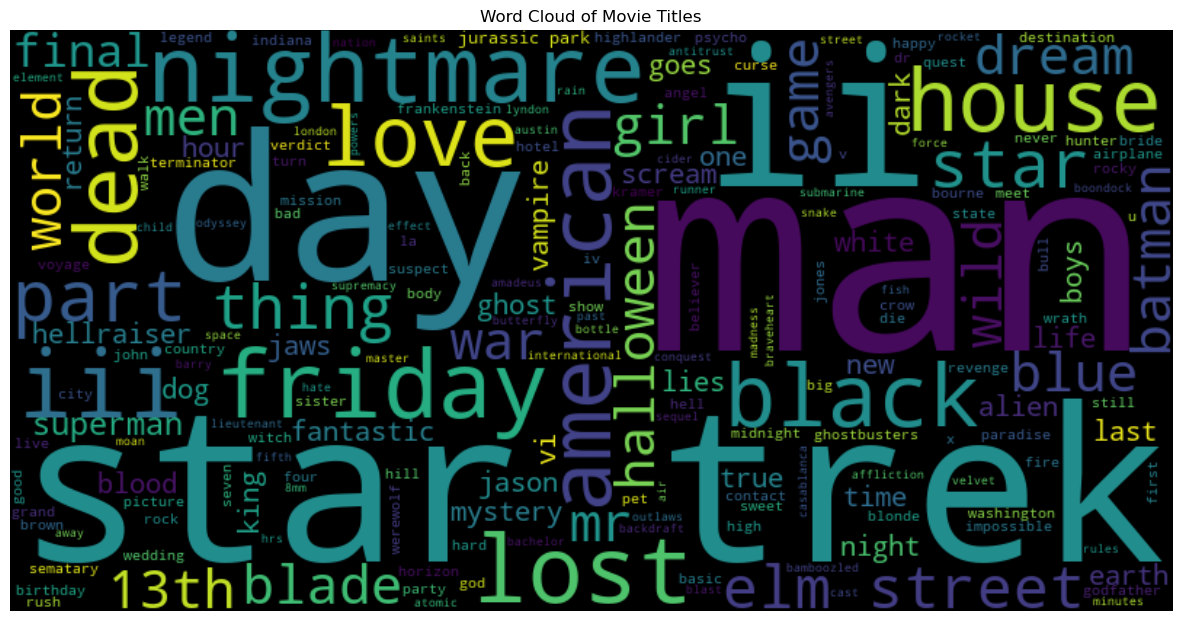

In [45]:
#Concatenate all dialogue lines
all_lines = ' '.join(movie_names_df['movie_name'])

#Create a word cloud with larger figure size
plt.figure(figsize=(15, 10))
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_lines)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Titles')
plt.show()

The most frequent words in the movie titles are **“star”, “trek”, “black”, “men”, “day”, “night”, “american”, “dead”, “thing”, “house”, “nightmare”, “elm”, “street”, “batman”, “jurassic”, “park”, “wild”, “lost”, “world”, “brown”, “jaws”, “mission”, “impossible”, “voyage”, “earth”, “game”, “happy”, “hotel”, “meet”, “hard”, “scream”, “basic”, “rush”, “13th”, “part”, “final”, “blue”, “hellraiser”, “dark”, “friday”, “thing”, “scream” **.

<br>



Based on this word cloud, we can conclude that the most common themes in the movie titles are related to **science fiction, horror, action, and adventure genres**. The words “star”, “trek”, “black”, “men”, “day”, “night”, “american”, “dead”, “thing”, “house”, “nightmare”, “elm”, “street”, “batman”, “jurassic”, “park”, “wild”, “lost”, “world”, “brown”, “jaws”, “mission”, “impossible”, “voyage”, “earth”, “game”, “happy”, “hotel”, “meet”, “hard”, “scream”, “basic”, “rush”, “13th”, “part”, “final”, “blue”, “hellraiser”, “dark”, “friday”, “thing”, and “scream” are indicative of the most popular movie franchises and titles in these genres.

### Creating Wordcloud out of Character Names

In [46]:
character_names_df = df.drop_duplicates(subset = "character_id")
character_names_df.character_name

0                  BIANCA
97                CAMERON
180                  JOEY
216                   KAT
367              MANDELLA
               ...       
288098          ELIZABETH
288153             FREDDY
288422               IGOR
288524               INGA
288604    MEDICAL STUDENT
Name: character_name, Length: 2951, dtype: object

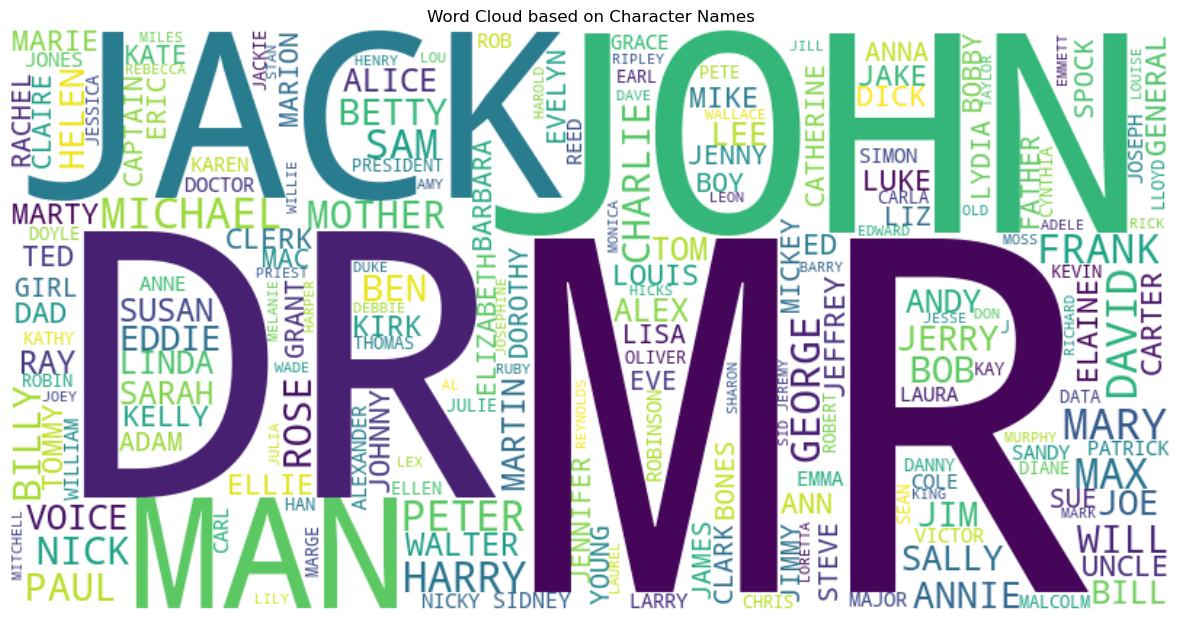

In [47]:
#Concatenate all dialogue lines
all_lines = ' '.join(character_names_df['character_name'])

#Create a word cloud with larger figure size
plt.figure(figsize=(15, 10))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_lines)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud based on Character Names')
plt.show()

Based on the word cloud, we can conclude that the most common character names in the 588 movies are ***Jack, John, Michael, George, and Nick***. We can also see that there are other names that are less common, but still appear in the word cloud such as ***Paul, Sam, Betty, Kirk, and Tom***.

### Gender Distribution of movie Characters across movies in given data

In [48]:
Gender_distribution = df.drop_duplicates(subset = "character_id")
Gender_distribution

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_name,director_gender,character_id,character_name,character_gender,position_credits,line_id,character_line,character_dialog_count,dialog_word_count,dialog_length
0,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L1045,They do not!,94,3,12
97,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u2,CAMERON,M,3,L1044,They do to!,75,3,11
180,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u4,JOEY,M,6,L759,Listen I want to talk to you about the prom.,36,10,44
216,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u5,KAT,F,2,L1052,Perm?,150,1,5
367,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u6,MANDELLA,F,7,L948,William - he asked me to meet him here.,25,9,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288098,m615,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,u9015,ELIZABETH,F,25,L666202,So this is what it's like to be completely happy!,44,10,49
288153,m615,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,u9017,FREDDY,M,-1,L666092,I think we all need a good night's sleep. Why...,252,21,97
288422,m615,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,u9019,IGOR,M,3,L665975,Miss me?,102,2,8
288524,m615,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,u9020,INGA,F,5,L666221,Sweetheart.....Is this really you???,73,4,36


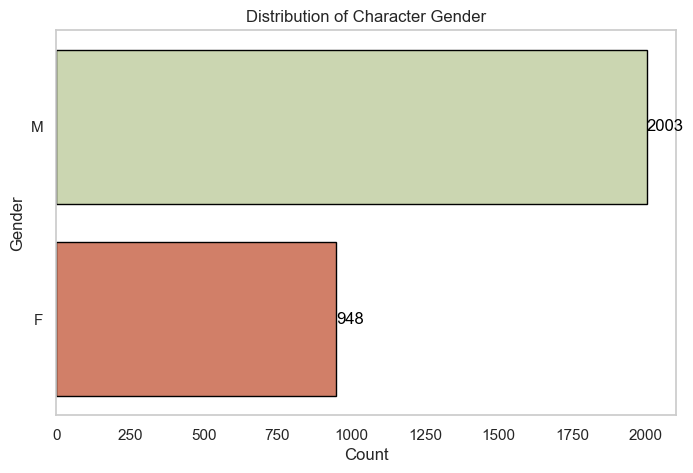

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each unique value in 'character_gender'
gender_counts = Gender_distribution['character_gender'].value_counts()

# Create a horizontal bar plot using seaborn with custom colors
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
ax = sns.barplot(x=gender_counts.values, y=gender_counts.index, palette=['#cedcab', '#e27557'], edgecolor='black')

# Set labels and title
plt.xlabel('Count')
plt.ylabel('Gender')
plt.title('Distribution of Character Gender')

# Remove grid lines
ax.grid(False)

# Add count labels on the bars
for i, v in enumerate(gender_counts.values):
    ax.text(v + 0.1, i, str(v), color='black', ha='left', va='center')

# Show the plot
plt.show()

We have total of **2951 Characters** across 588 Movies.

Out of these ***2003 Characters are of Male Gender and 948 Female***

### Now, Let's see how the data for movies is distributed over the years italicized text

In [50]:
movie_year_df = df.drop_duplicates(subset = "movie_id")
movie_year_df

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_name,director_gender,character_id,character_name,character_gender,position_credits,line_id,character_line,character_dialog_count,dialog_word_count,dialog_length
0,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L1045,They do not!,94,3,12
694,m1,1492: conquest of paradise,1992,6.2,['adventure' 'biography' 'drama' 'history'],Ridley Scott,M,u16,COLUMBUS,M,1,L2024,Asia can be found to the west -- and I will pr...,117,13,53
927,m2,15 minutes,2001,6.1,['action' 'crime' 'drama' 'thriller'],John Herzfeld,M,u26,CUTLER,M,-1,L3546,Officers there's your killer do your duty arre...,24,9,53
1605,m3,2001: a space odyssey,1968,8.4,['adventure' 'mystery' 'sci-fi'],Stanley Kubrick,M,u50,BOWMAN,M,1,L4300,Roger.,58,1,6
1906,m4,48 hrs.,1982,6.9,['action' 'comedy' 'crime' 'drama' 'thriller'],Walter Hill,M,u67,CATES,M,1,L5328,Where's ganz?,224,2,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286252,m610,the wizard of oz,1939,8.3,['adventure' 'family' 'fantasy' 'musical'],Unknown,Unknown,u8950,DOROTHY,F,1,L660491,No Aunt Em -- this was a real truly live place...,187,22,100
286830,m611,the world is not enough,1999,6.3,['action' 'adventure' 'thriller'],Michael Apted,M,u8965,BOND,M,1,L663195,I love Christmas in Turkey.,131,5,27
287162,m612,watchmen,2009,7.8,['action' 'crime' 'fantasy' 'mystery' 'sci-fi'...,Zack Snyder,M,u8979,DR. MANHATTAN,M,2,L664175,WHAT ARE YOU DOING VEIDT?,35,5,25
287505,m613,xxx,2002,5.6,['action' 'adventure' 'crime'],Rob Cohen,M,u8991,GIBBONS,M,4,L665330,All for show. Just a psychological mind game t...,51,16,78


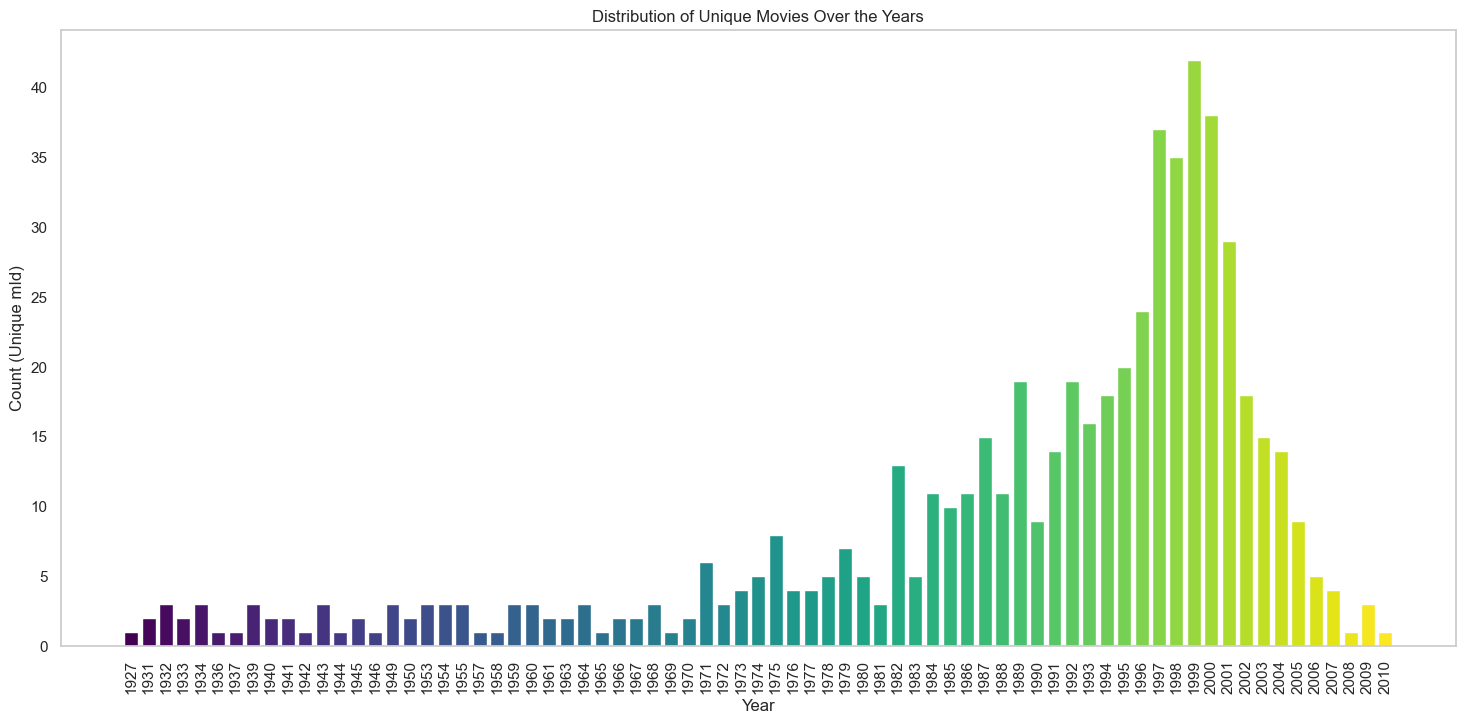

In [51]:
# Count the occurrences of each year based on unique mId values
year_counts_unique = movie_year_df.groupby('movie_year')['movie_id'].nunique()

# Create a color gradient
colors = plt.cm.viridis(np.linspace(0, 1, len(year_counts_unique)))

# Create a bar plot for year distribution based on unique mId
plt.figure(figsize=(18, 8))  # Adjust the figure size as needed
bars = plt.bar(year_counts_unique.index.astype(str), year_counts_unique, color=colors)
plt.xlabel('Year')
plt.ylabel('Count (Unique mId)')
plt.title('Distribution of Unique Movies Over the Years')

# Remove grids
plt.grid(False)

# Create a ScalarMappable to create a colorbar
sm = ScalarMappable(cmap=plt.cm.viridis)
sm.set_array([])  # An array must be set, but it can be empty

# # Add a color bar for the gradient
# color_bar = plt.colorbar(sm, orientation='vertical', pad=0.05)
# color_bar.set_label('Color Gradient')

# Adjust x-axis limits for a little space on both sides
plt.margins(x=0.05)

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

The data ranges from the year 1926 all the way upto 2010. While we have wide-ranging data, the majority of it lies in the 3 decades of the 1980s, 1990s and 2000s, with 490 of the 617 i.e., ∼79% of the movies in that period. This sample space has enough of a time-spread for us to analyze how representation of women and the general attitude towards them in movies has changed over time.

### Analysing Movies for Ratings Received

In [52]:
movie_rating_df = df.drop_duplicates(subset = "movie_id")
movie_rating_df

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_name,director_gender,character_id,character_name,character_gender,position_credits,line_id,character_line,character_dialog_count,dialog_word_count,dialog_length
0,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L1045,They do not!,94,3,12
694,m1,1492: conquest of paradise,1992,6.2,['adventure' 'biography' 'drama' 'history'],Ridley Scott,M,u16,COLUMBUS,M,1,L2024,Asia can be found to the west -- and I will pr...,117,13,53
927,m2,15 minutes,2001,6.1,['action' 'crime' 'drama' 'thriller'],John Herzfeld,M,u26,CUTLER,M,-1,L3546,Officers there's your killer do your duty arre...,24,9,53
1605,m3,2001: a space odyssey,1968,8.4,['adventure' 'mystery' 'sci-fi'],Stanley Kubrick,M,u50,BOWMAN,M,1,L4300,Roger.,58,1,6
1906,m4,48 hrs.,1982,6.9,['action' 'comedy' 'crime' 'drama' 'thriller'],Walter Hill,M,u67,CATES,M,1,L5328,Where's ganz?,224,2,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286252,m610,the wizard of oz,1939,8.3,['adventure' 'family' 'fantasy' 'musical'],Unknown,Unknown,u8950,DOROTHY,F,1,L660491,No Aunt Em -- this was a real truly live place...,187,22,100
286830,m611,the world is not enough,1999,6.3,['action' 'adventure' 'thriller'],Michael Apted,M,u8965,BOND,M,1,L663195,I love Christmas in Turkey.,131,5,27
287162,m612,watchmen,2009,7.8,['action' 'crime' 'fantasy' 'mystery' 'sci-fi'...,Zack Snyder,M,u8979,DR. MANHATTAN,M,2,L664175,WHAT ARE YOU DOING VEIDT?,35,5,25
287505,m613,xxx,2002,5.6,['action' 'adventure' 'crime'],Rob Cohen,M,u8991,GIBBONS,M,4,L665330,All for show. Just a psychological mind game t...,51,16,78


In [53]:
movie_rating_df.movie_rating.describe()

count    588.000000
mean       6.867347
std        1.216800
min        2.500000
25%        6.200000
50%        7.100000
75%        7.800000
max        9.300000
Name: movie_rating, dtype: float64

We observe that the highest Rated movie had 9.3 Rating

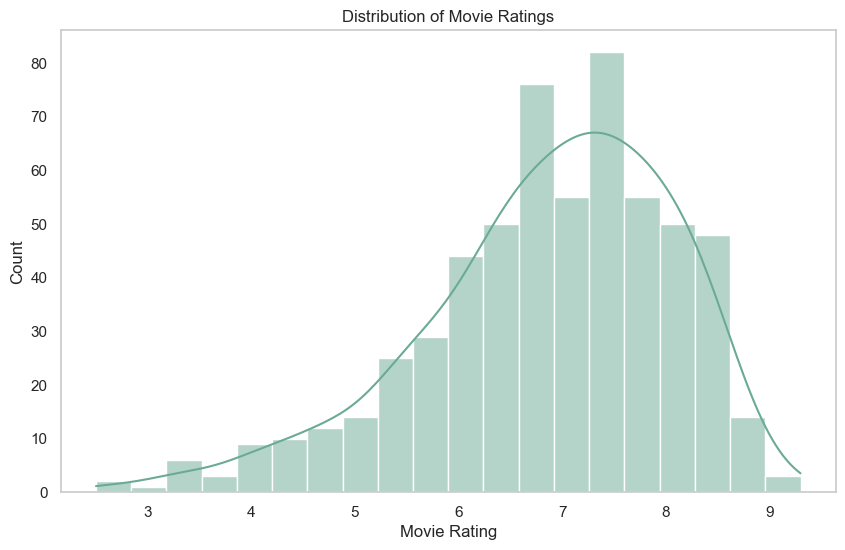

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

#Assuming your analysis DataFrame is named analysis_df
#Extract the 'movie_rating' column for plotting
movie_ratings = movie_rating_df['movie_rating']

#Create a histogram for movie ratings
plt.figure(figsize=(10, 6))
sns.histplot(movie_ratings, bins=20, kde=True, color='#6aaa96')
plt.xlabel('Movie Rating')
plt.ylabel('Count')
plt.title('Distribution of Movie Ratings')

# Remove grids
plt.grid(False)

#Show the plot
plt.show()

Based on the graph, we can conclude that the majority of the movies have a rating between 6 and 8. The highest number of ratings is around 7.5. This suggests that most movies are rated between 6 and 8, with a few outliers on either end.

**9.5 is the highest rating received by any movie in our current dataset.**

### Let's Explore dialogue count per Gender

In [55]:
gender_dialogue_df = df.drop_duplicates(subset = "character_id")
gender_dialogue_df

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_name,director_gender,character_id,character_name,character_gender,position_credits,line_id,character_line,character_dialog_count,dialog_word_count,dialog_length
0,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L1045,They do not!,94,3,12
97,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u2,CAMERON,M,3,L1044,They do to!,75,3,11
180,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u4,JOEY,M,6,L759,Listen I want to talk to you about the prom.,36,10,44
216,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u5,KAT,F,2,L1052,Perm?,150,1,5
367,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u6,MANDELLA,F,7,L948,William - he asked me to meet him here.,25,9,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288098,m615,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,u9015,ELIZABETH,F,25,L666202,So this is what it's like to be completely happy!,44,10,49
288153,m615,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,u9017,FREDDY,M,-1,L666092,I think we all need a good night's sleep. Why...,252,21,97
288422,m615,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,u9019,IGOR,M,3,L665975,Miss me?,102,2,8
288524,m615,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,u9020,INGA,F,5,L666221,Sweetheart.....Is this really you???,73,4,36


In [56]:
dialogue_per_gender = gender_dialogue_df.groupby('character_gender')['character_dialog_count'].sum()

In [57]:
dialogue_per_gender

character_gender
F     67862
M    161244
Name: character_dialog_count, dtype: int64

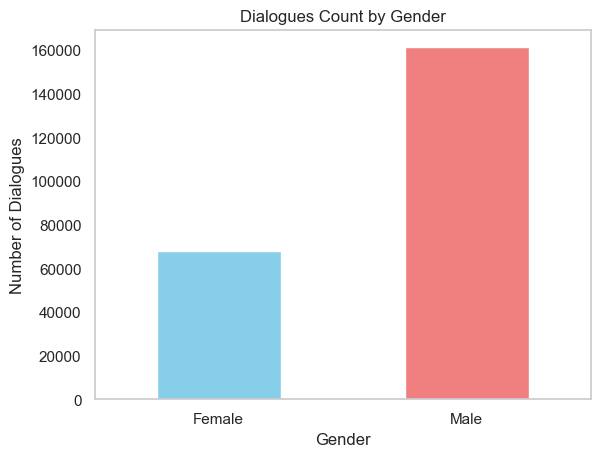

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
dialogue_df = pd.DataFrame({'Gender':['Female', 'Male'], 'dialogue_per_gender':[dialogue_per_gender[0], dialogue_per_gender[1]]})

# Create a bar plot
ax = dialogue_df.plot.bar(x='Gender', y='dialogue_per_gender', rot=0, color=['skyblue', 'lightcoral'])
ax.get_legend().remove()
# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Number of Dialogues')
plt.title('Dialogues Count by Gender')
plt.grid(False)
# Show the plot
plt.show()

The bar graph illustrates the distribution of dialogues between female and male characters.The data indicates that male characters have significantly more dialogues **(161244)** compared to female characters **(67862)**. This suggests a potential gender imbalance in the dataset or narrative focus.

The substantial difference in dialogue counts raises questions about the representation of female characters in the context of the dataset. The analysis may prompt further investigation into the storyline, genre, or specific characters contributing to these numbers.

In [59]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

from imblearn.under_sampling import RandomUnderSampler

import IPython
from IPython.display import display
import graphviz
from sklearn.tree import export_graphviz
import re


warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)

In [60]:
final_df.head()

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_name,director_gender,character_id,character_name,character_gender,position_credits,line_id,character_line,character_dialog_count,dialog_word_count,dialog_length
0,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L1045,They do not!,94,3,12
1,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L985,I hope so.,94,3,10
2,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L925,Let's go.,94,2,9
3,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L872,Okay -- you're gonna need to learn how to lie.,94,10,46
4,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L869,Like my fear of wearing pastels?,94,6,32


**Feature** **Engineering**




Next, let's convert the dialogues into clean tokens

Remove Stopwords : because they occur very often, but serve no meaning. e.g. : is,am,are,the.
Turn all word to smaller cases : I, i -> i
walk,walks -> walk or geographical,geographic -> geographic
#Lemmatization

In [61]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mkaur711\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mkaur711\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [62]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Download wordnet resource
nltk.download('wordnet')

wordnet_lemmatizer = WordNetLemmatizer()

def clean_dialogue(character_line):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and
    # the output is a single string (a preprocessed movie review)
    # Source : https://www.kaggle.com/akerlyn/wordcloud-based-on-character
    #
    # 1. Remove HTML
    #
    # 2. Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", character_line)
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))

    # 5. Use lemmatization and remove stop words
    meaningful_words = [wordnet_lemmatizer.lemmatize(w) for w in words if not w in stops]
    #
    # 6. Join the words back into one string separated by space,
    # and return the result.
    return " ".join(meaningful_words)

final_df['cleaned_dialogue'] = final_df['character_line'].apply(clean_dialogue)
final_df[['character_line', 'cleaned_dialogue']].sample(5)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mkaur711\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,character_line,cleaned_dialogue
211986,Thanks Max. Or is it Maxine?,thanks max maxine
60274,Where's the girl? Miss Stone.,girl miss stone
37898,Yes... A man I know took me to Switzerland las...,yes man know took switzerland last month
222817,You don't remember me do you?,remember
171645,But I did. I'm positive!,positive


In [63]:
final_df.head()

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_name,director_gender,character_id,character_name,character_gender,position_credits,line_id,character_line,character_dialog_count,dialog_word_count,dialog_length,cleaned_dialogue
0,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L1045,They do not!,94,3,12,
1,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L985,I hope so.,94,3,10,hope
2,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L925,Let's go.,94,2,9,let go
3,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L872,Okay -- you're gonna need to learn how to lie.,94,10,46,okay gonna need learn lie
4,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L869,Like my fear of wearing pastels?,94,6,32,like fear wearing pastel


**Data Analysis Based On the Gender Of The Director**

In [64]:
df_director_rating = final_df.copy()
df_director_rating = df_director_rating[['movie_name', 'movie_year', 'movie_rating', 'movie_genre', 'director_name', 'director_gender']].drop_duplicates()

# Filtering the DataFrame for female directors
female_directors_df = df_director_rating[df_director_rating['director_gender'] == 'F']

# Filtering the DataFrame for male directors
male_directors_df = df_director_rating[df_director_rating['director_gender'] == 'M']

# Merging female and male directors DataFrames based on common columns
merged_df = pd.merge(female_directors_df, male_directors_df, on=['movie_year', 'movie_genre'], how='inner', suffixes=('_female', '_male'))

# Getting the number of movies made
unique_movies_female = female_directors_df.groupby(['movie_name', 'movie_year']).size().reset_index(name='count').shape[0]
unique_movies_male = male_directors_df.groupby(['movie_name', 'movie_year']).size().reset_index(name='count').shape[0]

print(f"Number of unique movies made by female directors: {unique_movies_female}")
print(f"Number of unique movies made by male directors: {unique_movies_male}")

# Counting the number of movies for each combination of year and genre
movies_count_by_year_genre = merged_df.groupby(['movie_year', 'movie_genre']).size().reset_index(name='movie_count')
print("Number of movies made on same year and in same genre by both male and female directors: ", len(movies_count_by_year_genre))




Number of unique movies made by female directors: 15
Number of unique movies made by male directors: 464
Number of movies made on same year and in same genre by both male and female directors:  0


The aforementioned analysis reveals that there is a notable disparity in the number of unique movies made by female and male directors. Furthermore, there are no common movies made by both male and female directors in the same year and genre, suggesting a potential lack of overlap in the types of projects undertaken by directors of different genders.

This analysis provides valuable insights into the distribution and collaboration patterns among female and male directors. Further exploration and investigation into the factors influencing these disparities could contribute to a better understanding of gender dynamics in the film industry.

**`Identifying The Trend In Movie Ratings`**

The project's findings underscore the significant class imbalance in the number of movies made by male and female directors. While female directors have shown strength in certain genres, the absence of a clear trend over the years suggests a need for more comprehensive data to draw definitive conclusions.

The observations align with societal expectations and gender preferences, evident in the genre choices made by female directors. The disparities in performance across genres may reflect broader biases or audience expectations, especially in genres traditionally associated with male-directed films.

This analysis provides valuable insights for stakeholders in the film industry, emphasizing the importance of diversity in storytelling and the need for further exploration into audience perceptions and biases.


**`Key Insights:`**

**Genre Performance:**

**Drama and Drama-Thriller:**

Female directors exhibited superior performance in genres such as Drama and Drama-Thriller, reflecting their prowess in nuanced storytelling.

**Action Genre:**

Strikingly, there was a notable absence of female directors in the action genre. This aligns with societal gender norms and prevalent tastes.

**Other Genres:**

In other common genres, male directors tended to outperform their female counterparts. This outcome could stem from perceived differences in work quality or audience biases, particularly evident in genres like sports and crime.

**Rating Trends Over Years:**

Despite the meticulous analysis, no discernible trend emerged over the years based on the gender of the director. This inconclusiveness is attributed to the insufficient data available for films directed by females.



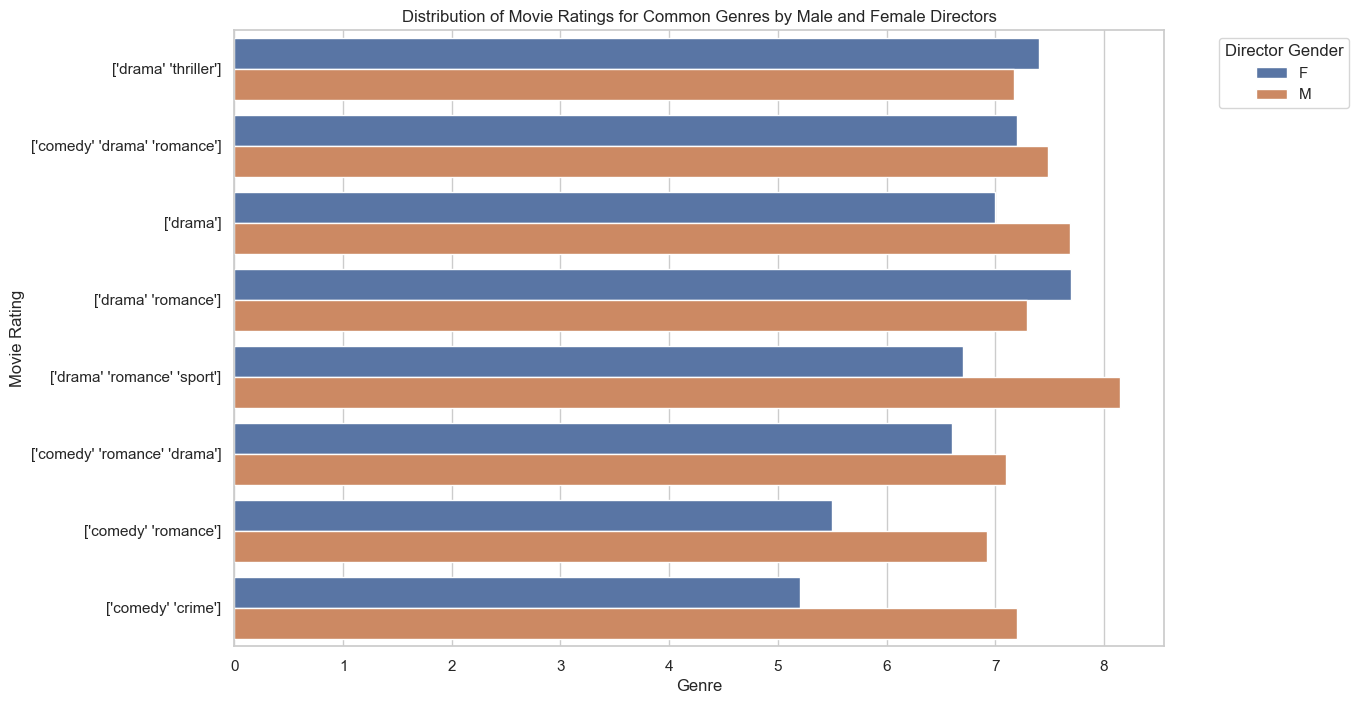

In [65]:
# Identifying common genres for both female and male directors
common_genres = set(female_directors_df['movie_genre']).intersection(set(male_directors_df['movie_genre']))

# Filtering the DataFrames for common genres
female_directors_common_df = female_directors_df[female_directors_df['movie_genre'].isin(common_genres)]
male_directors_common_df = male_directors_df[male_directors_df['movie_genre'].isin(common_genres)]

# Creating a bar plot for the distribution of movie ratings for common genres
plt.figure(figsize=(12, 8))
sns.barplot(x='movie_rating', y='movie_genre', hue='director_gender', data=pd.concat([female_directors_common_df, male_directors_common_df]), ci=None)
plt.title('Distribution of Movie Ratings for Common Genres by Male and Female Directors')
plt.xlabel('Genre')
plt.ylabel('Movie Rating')
plt.legend(title='Director Gender', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.show()

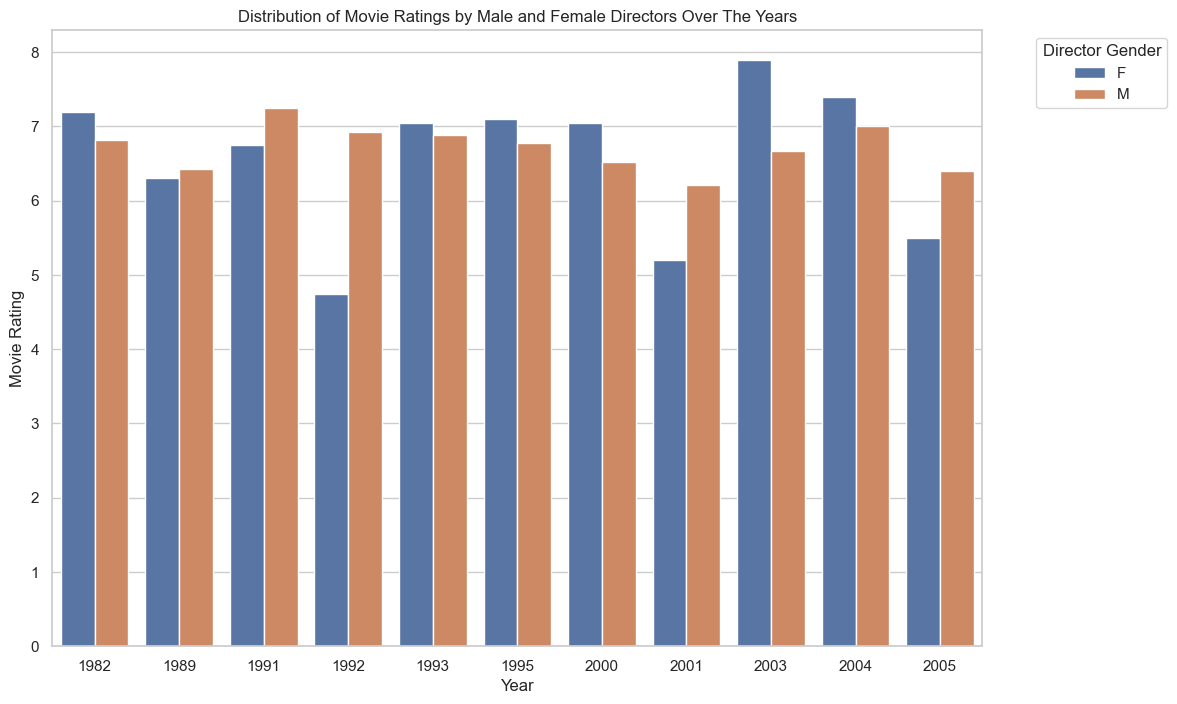

In [66]:
# Identifying common years for both female and male directors
common_years = sorted(set(female_directors_df['movie_year']).intersection(set(male_directors_df['movie_year'])))

# Identifying common years for both female and male directors
common_year = set(female_directors_df['movie_year']).intersection(set(male_directors_df['movie_year']))

# Filtering the DataFrames for common years
female_directors_common_df = female_directors_df[female_directors_df['movie_year'].isin(common_year)]
male_directors_common_df = male_directors_df[male_directors_df['movie_year'].isin(common_year)]

# Creating a bar plot for the distribution of movie ratings for common years
plt.figure(figsize=(12, 8))
sns.barplot(x='movie_year', y='movie_rating', hue='director_gender', data=pd.concat([female_directors_common_df, male_directors_common_df]), ci=None)
plt.title('Distribution of Movie Ratings by Male and Female Directors Over The Years')
plt.xlabel('Year')
plt.ylabel('Movie Rating')
plt.xticks(ticks=range(len(common_years)), labels=common_years) 
plt.legend(title='Director Gender', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


**Data Preparation For Model Building**

In [67]:
train_data = final_df.groupby(['character_id', 'movie_id', 'character_name', 'character_gender', 'position_credits','movie_year', 'movie_genre', 'director_name','director_gender']). \
            agg({'dialog_length' : ['median'],
                 'dialog_word_count' : ['median'],
                 'character_id' : ['count'],
                 'cleaned_dialogue' : [lambda x : ' '.join(x)]
                })

## Renaming columns by aggregate functions
train_data.columns = ["_".join(x) for x in train_data.columns.ravel()]

train_data.reset_index(inplace=True)
train_data

,character_id,movie_id,character_name,character_gender,position_credits,movie_year,movie_genre,director_name,director_gender,dialog_length_median,dialog_word_count_median,character_id_count,cleaned_dialogue_<lambda>
0,u0,m0,BIANCA,F,4,1999,['comedy' 'romance'],Gil Junger,M,34.0,7.0,94,hope let go okay gonna need learn lie like fe...
1,u100,m6,AMY,F,7,1999,['crime' 'mystery' 'thriller'],Joel Schumacher,M,23.0,4.0,31,died sleep three day ago paper tom dead calli...
2,u1003,m65,RICHARD,M,3,1996,['action' 'crime' 'horror' 'thriller'],Robert Rodriguez,M,24.5,5.0,70,asked would said room room serious foolin arou...
3,u1005,m65,SETH,M,2,1996,['action' 'crime' 'horror' 'thriller'],Robert Rodriguez,M,37.0,8.0,163,let follow said new jesus christ carlos brothe...
4,u1008,m66,C.O.,M,17,1997,['action' 'drama'],Ridley Scott,M,48.0,9.0,33,course uh v p security arrangement generally t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,u980,m63,VICTOR,M,3,1931,['drama' 'horror' 'sci-fi'],James Whale,M,32.0,6.0,126,never said name remembers kill draw line take...
2947,u983,m64,ALICE,F,-1,2009,['horror'],Marcus Nispel,M,30.0,6.0,51,maybe wait mr christy killer still bill bill b...
2948,u985,m64,BILL,M,-1,2009,['horror'],Marcus Nispel,M,20.0,4.0,39,twenty mile crossroad steve back hour thing st...
2949,u997,m65,JACOB,M,1,1996,['action' 'crime' 'horror' 'thriller'],Robert Rodriguez,M,36.0,6.0,90,meant son daughter oh daughter bathroom vacati...


In [68]:
## Separating labels from features
y = train_data['character_gender']
X = train_data.copy()
X.drop('character_gender', axis=1, inplace=True)

## Removing unnecessary columns
X.drop('character_id', axis=1, inplace=True)
X.drop('movie_id', axis=1, inplace=True)
X.drop('character_name', axis=1, inplace=True)
X.drop('director_name', axis=1, inplace=True)
X.head()

,position_credits,movie_year,movie_genre,director_gender,dialog_length_median,dialog_word_count_median,character_id_count,cleaned_dialogue_<lambda>
0,4,1999,['comedy' 'romance'],M,34.0,7.0,94,hope let go okay gonna need learn lie like fe...
1,7,1999,['crime' 'mystery' 'thriller'],M,23.0,4.0,31,died sleep three day ago paper tom dead calli...
2,3,1996,['action' 'crime' 'horror' 'thriller'],M,24.5,5.0,70,asked would said room room serious foolin arou...
3,2,1996,['action' 'crime' 'horror' 'thriller'],M,37.0,8.0,163,let follow said new jesus christ carlos brothe...
4,17,1997,['action' 'drama'],M,48.0,9.0,33,course uh v p security arrangement generally t...


In [69]:
X.position_credits = X.position_credits.apply(lambda p: '10+' if not p in range(0,10) else p)  ## Label encoding

In [70]:
X.position_credits.value_counts()

10+    754
1      489
2      434
3      345
4      260
5      204
6      166
7      122
8       99
9       78
Name: position_credits, dtype: int64

In [71]:
print("Data Snapshot")
X.head()

Data Snapshot


,position_credits,movie_year,movie_genre,director_gender,dialog_length_median,dialog_word_count_median,character_id_count,cleaned_dialogue_<lambda>
0,4,1999,['comedy' 'romance'],M,34.0,7.0,94,hope let go okay gonna need learn lie like fe...
1,7,1999,['crime' 'mystery' 'thriller'],M,23.0,4.0,31,died sleep three day ago paper tom dead calli...
2,3,1996,['action' 'crime' 'horror' 'thriller'],M,24.5,5.0,70,asked would said room room serious foolin arou...
3,2,1996,['action' 'crime' 'horror' 'thriller'],M,37.0,8.0,163,let follow said new jesus christ carlos brothe...
4,10+,1997,['action' 'drama'],M,48.0,9.0,33,course uh v p security arrangement generally t...


**Pipeline For Classifiers**

In this project, we have used pipelines and vectorizers. The vectorizer takes in every word of the column and it doesnot add one row at a time. Hence a coverter is needed to feed the input to the vectorizer.


In [72]:
class Converter(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, data_frame):
        return data_frame.values.ravel()

**Pipeline For Numeric Features**

In [73]:
numeric_features = ['dialog_length_median', 'dialog_word_count_median', 'character_id_count', 'movie_year']

##Created pipeline transformer for scaling numeric data
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

**Pipeline For Non-Numeric Feature**

The colum ['director_gender', 'movie_genre'] is a good candidate for OrdinalEncoder as the categorical features have ordinal data.

In [74]:
label_features = ['director_gender', 'movie_genre']

class OrdinalEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

    def fit(self, X, y=None):
        self.ordinal_encoder.fit(X[self.columns])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.columns] = self.ordinal_encoder.transform(X[self.columns])
        return X_copy

# Create a pipeline transformer for ordinal data
label_transformer = OrdinalEncoderTransformer(columns=label_features)


The colum ['position_credits'] is a good candidate for one-hot encoding as the categorical features here have nominal data (where there is no inherent order among categories).

In [75]:
##This ensures all rows are uniformly string type to make it compitable to OneHotEncoder
X['position_credits'] = X['position_credits'].astype(str)

nominal_features = ['position_credits']

##Created pipeline transformer for nominal data
nominal_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

The vectorizer takes in every word of the column and it doesnot add one row at a time. Hence a coverter is needed to feed the input to the vectorizer.
The below pipeline feeds the data to the vectorizer and ensure Tfid distribution is generated for each word in the column

In [76]:
vectorizer_features = ['cleaned_dialogue_<lambda>']

##Creating pipeline transformer to feed input to Vectorizer and then generating Tfid distribution
vectorizer_transformer = Pipeline(steps=[('con', Converter()),('tf', TfidfVectorizer())])

**Creating Preprocessor Pipeline**

This preprocessor pipeline consist of all the above generated pipelines to address the transformation associated with numeric features, ordianl features, nomial feature and TfidVectorization. These are the essential preprocessing steps mandatory for datapreparation prior to model building.

In [77]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ord', label_transformer, label_features),
        ('nom', nominal_transformer, nominal_features),
        ('vec', vectorizer_transformer, vectorizer_features)
    ])

**Building Model**

The following models are being trained on data with no class balancing. This will be our baseline models for this project.

Here the hyperparameter "`stratify = y`" ensures that the class distribution in the original dataset is maintained in the train and validation sets. This is particularly useful when dealing with imbalanced datasets, where some classes may have significantly fewer samples than others.

Here, test_size set to 20%, meaning 80% of the data will be used for training, and 20% for validation.

In [78]:
##Creating dataset for model creation and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

y_test.value_counts()

M    401
F    190
Name: character_gender, dtype: int64

For this project we will build the following models:
- MultinomialNB
- Logistic Regression
- Random Forest
- Support Vector Classification (SVC)



`MultinomialNB` is a classification algorithm for text data in natural language processing. It assumes features follow a multinomial distribution, making it suitable for tasks like spam filtering or sentiment analysis. The algorithm uses Bayes' theorem, with Laplace smoothing to handle unseen features. It efficiently processes high-dimensional data and is implemented in Python with scikit-learn, involving vectorization of text and training the classifier. The smoothing parameter (alpha) can be tuned for optimal performance.


For this project, we selected MultinomialNB over GaussianNB because we choose MultinomialNB when working with discrete data, especially in the context of text, and choose GaussianNB when dealing with continuous numerical data.

`Logistic Regression` is a widely used statistical method for binary classification that models the probability of an instance belonging to a particular class. Despite its name, it is a classification algorithm rather than a regression algorithm. Logistic Regression applies the logistic function (sigmoid) to a linear combination of input features, transforming the output into a range between 0 and 1. This output can be interpreted as the probability of the instance belonging to the positive class. The model is trained using a process called maximum likelihood estimation, adjusting the weights of the features to maximize the likelihood of the observed class labels. Logistic Regression is simple yet effective, easy to interpret, and performs well on linearly separable datasets. It finds applications in various fields, including healthcare, finance, and natural language processing.

`Random Forest` is a powerful ensemble learning algorithm widely used for both classification and regression tasks. It operates by constructing a multitude of decision trees during training and outputs the mode (for classification) or average prediction (for regression) of the individual trees. Each tree in the forest is constructed using a random subset of the training data and a random subset of the features. This randomness helps to decorrelate the trees and reduces overfitting. The algorithm combines the predictions of these diverse trees to provide a robust and accurate overall prediction. Random Forest is known for its flexibility, scalability, and ability to handle high-dimensional data with complex relationships. It is particularly effective in capturing non-linear patterns in data, making it a popular choice in various domains, including finance, bioinformatics, and image analysis.

`Support Vector Machines (SVMs)`, and specifically the `Support Vector Classification (SVC)` for classification tasks, are powerful supervised learning algorithms. SVMs aim to find the optimal hyperplane that separates different classes in the feature space while maximizing the margin, which is the distance between the hyperplane and the nearest data points of each class. SVC is particularly effective in high-dimensional spaces and is versatile in handling linear and non-linear relationships between features. It uses a kernel trick to implicitly map the input data into a higher-dimensional space, allowing it to learn complex decision boundaries. The regularization parameter in SVC helps control overfitting, and it is especially useful when dealing with small to medium-sized datasets. SVMs have found applications in various fields, including image classification, text categorization, and bioinformatics, where their ability to handle both linear and non-linear relationships provides a significant advantage.

For hyperparameter tuning we have used the `RandomizedSearchCV` technique.

RandomizedSearchCV is a hyperparameter tuning technique that efficiently explores the hyperparameter space of machine learning models by randomly sampling a specified number of parameter combinations. It is particularly useful for models like Random Forest or Support Vector Machines (SVMs) where optimal hyperparameter selection significantly impacts performance. By conducting a randomized search and evaluating model performance using cross-validation, RandomizedSearchCV automates the process of finding the best hyperparameter configuration, making it a valuable tool for enhancing model efficiency and fine-tuning.

Here we will report the performance of each model on the basis of the following criteria:

1. **Precision:**
   - Precision is the ratio of correctly predicted positive observations to the total predicted positives. It is a measure of the accuracy of the positive predictions. The formula for precision is given by `TP/(TP + FP)` , where TP is the number of true positives, and FP is the number of false positives.


2. **Recall (Sensitivity or True Positive Rate):**
   - Recall is the ratio of correctly predicted positive observations to all actual positives. It measures the ability of the model to capture all relevant instances. The formula for recall is `TP/(TP + FN)`, where TP is the number of true positives, and FN is the number of false negatives.


3. **F1-Score:**
   - The F1-Score is the harmonic mean of precision and recall. It provides a balance between precision and recall. The formula for F1-Score is `TP/(TP + 1/2 * (FP * FN))`.


4. **Support:**
   - Support is the number of actual occurrences of each class in the specified dataset. It is the number of instances that belong to a certain class.


5. **Accuracy:**
   - Accuracy is the ratio of correctly predicted observations to the total observations. It measures overall correctness. The formula for accuracy is `(TP + TN)/(TP + TN + FP + FN)`, where TP is true positives, TN is true negatives, FP is false positives, and FN is false negatives.


6. **AUC (Area Under the ROC Curve):**
   - AUC is the area under the Receiver Operating Characteristic (ROC) curve. It measures the model's ability to distinguish between positive and negative instances. AUC ranges from 0 to 1, where a higher AUC indicates better model performance.


7. **Confusion Matrix:**
   - A confusion matrix is a table that summarizes the performance of a classification algorithm. It shows the counts of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN). These elements help in calculating various performance metrics.
   


   |              | Predicted Positive | Predicted Negative |
   |--------------|--------------------|--------------------|
   | Actual Positive | True Positive (TP) | False Negative (FN) |
   | Actual Negative | False Positive (FP) | True Negative (TN) |
   

These metrics are fundamental for evaluating the performance of classification models and are commonly used to assess how well a model generalizes to new data.

Classification Report for  Naive Bayes
              precision    recall  f1-score   support

           F       0.52      0.36      0.43       190
           M       0.74      0.84      0.79       401

    accuracy                           0.69       591
   macro avg       0.63      0.60      0.61       591
weighted avg       0.67      0.69      0.67       591

Naive Bayes Accuracy: 0.689
Naive Bayes AUC: 0.709


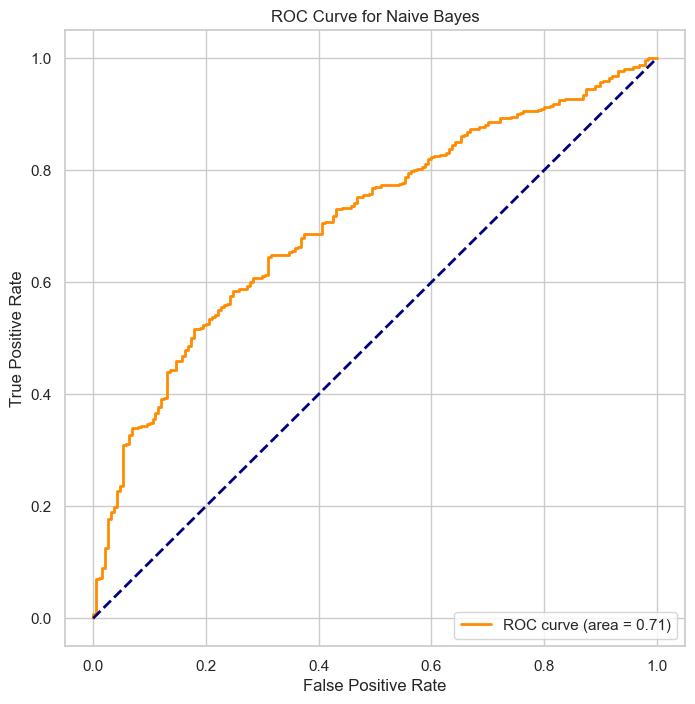

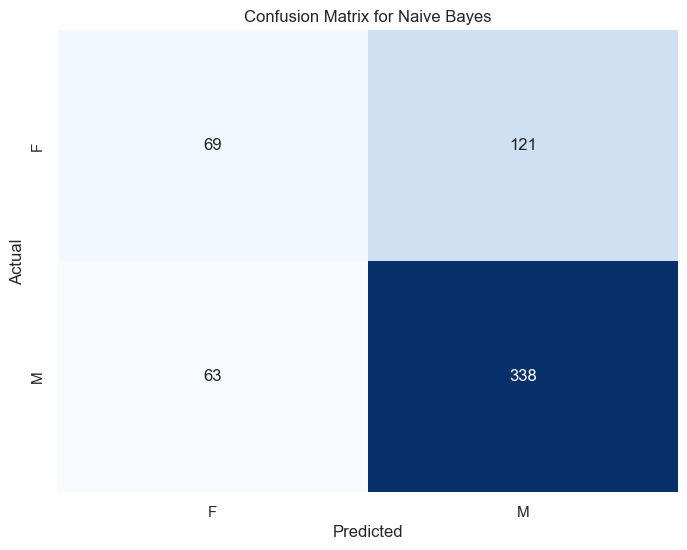

In [79]:
model_name = 'Naive Bayes'
# Define the pipeline with the preprocessor and the Naive Bayes model
pipeline_nb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__alpha': [0.01, 0.1, 1.0],
}

# Set up RandomizedSearchCV
model_nb = RandomizedSearchCV(
    pipeline_nb,
    param_distributions=param_dist,
    n_iter=10,  
    cv=5,
    n_jobs = -1,
    random_state=42
)

model_nb.fit(X_train, y_train)

best_params = model_nb.best_params_

# Create a new pipeline with the best parameters
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB(alpha=best_params['classifier__alpha']))
])

# Fit the model on the entire training dataset
best_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = best_pipeline.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary = y_test.map(label_mapping)
y_pred_binary = pd.Series(y_pred).map(label_mapping)

# Print accuracy on the test set
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"{model_name} Accuracy: {accuracy:.3f}")

# Calculate AUC
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1] 
auc = roc_auc_score(y_test_binary, y_pred_proba)
print(f"{model_name} AUC: {auc:.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


Classification Report for  Logistic Regression
              precision    recall  f1-score   support

           F       0.68      0.55      0.61       190
           M       0.80      0.88      0.84       401

    accuracy                           0.77       591
   macro avg       0.74      0.71      0.72       591
weighted avg       0.76      0.77      0.76       591

Logistic Regression Accuracy: 0.772
Logistic Regression AUC: 0.828


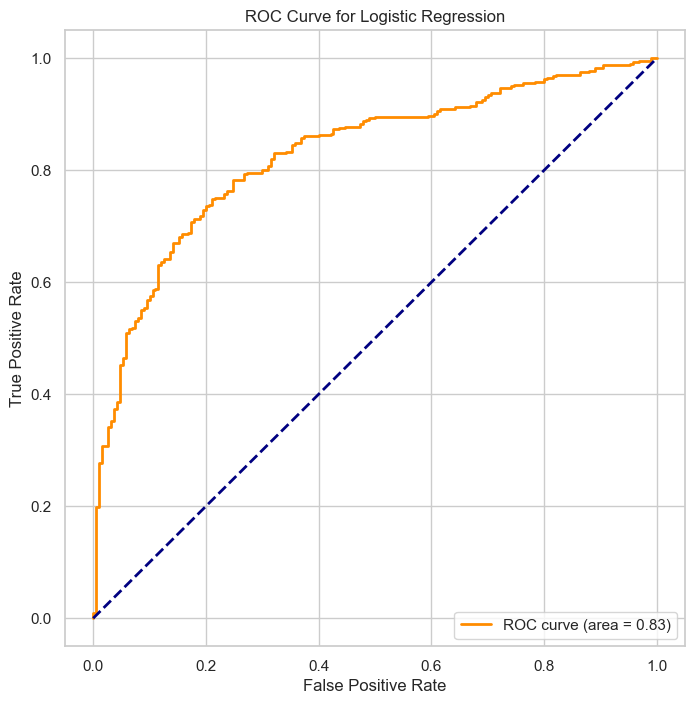

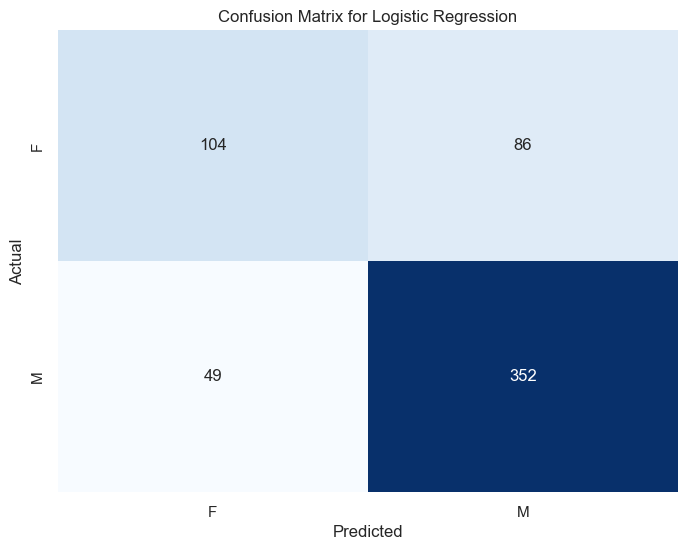

In [80]:
model_name = 'Logistic Regression'

# Define the pipeline with the preprocessor and the Logistic Regression model
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Set up RandomizedSearchCV
model_lr = RandomizedSearchCV(
    pipeline_lr,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=42
)

model_lr.fit(X_train, y_train)

best_params = model_lr.best_params_

# Create a new pipeline with the best parameters
best_pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty=best_params['classifier__penalty'], C=best_params['classifier__C']))
])

# Fit the model on the entire training dataset
best_pipeline_lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = best_pipeline_lr.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_lr))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_lr = y_test.map(label_mapping)
y_pred_binary_lr = pd.Series(y_pred_lr).map(label_mapping)

# Print accuracy on the test set
accuracy_lr = accuracy_score(y_test_binary_lr, y_pred_binary_lr)
print(f"{model_name} Accuracy: {accuracy_lr:.3f}")

# Calculate AUC
y_pred_proba_lr = best_pipeline_lr.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test_binary_lr, y_pred_proba_lr)
print(f"{model_name} AUC: {auc_lr:.3f}")

# Plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test_binary_lr, y_pred_proba_lr)
plt.figure(figsize=(8, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_lr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_lr = confusion_matrix(y_test_binary_lr, y_pred_binary_lr)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

Classification Report for  Random Forest
              precision    recall  f1-score   support

           F       0.85      0.06      0.11       190
           M       0.69      1.00      0.82       401

    accuracy                           0.69       591
   macro avg       0.77      0.53      0.46       591
weighted avg       0.74      0.69      0.59       591

Random Forest Accuracy: 0.694
Random Forest AUC: 0.802


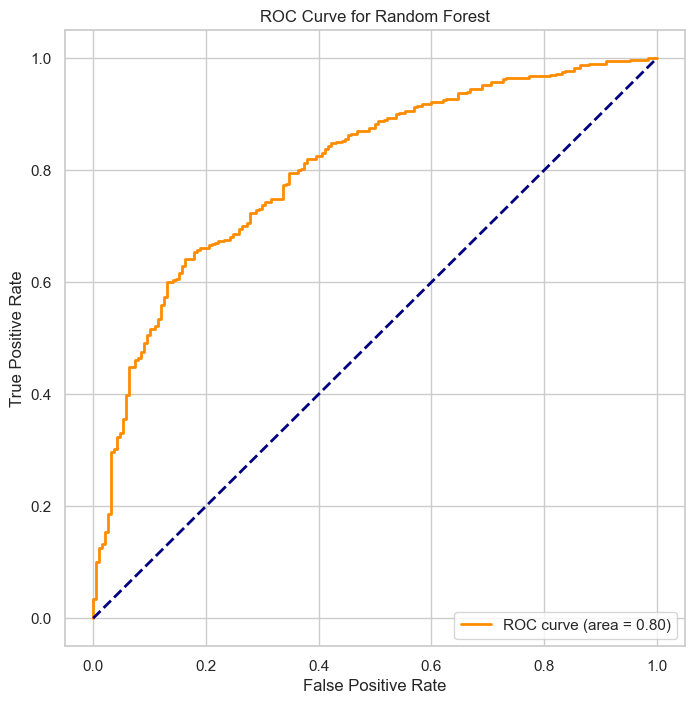

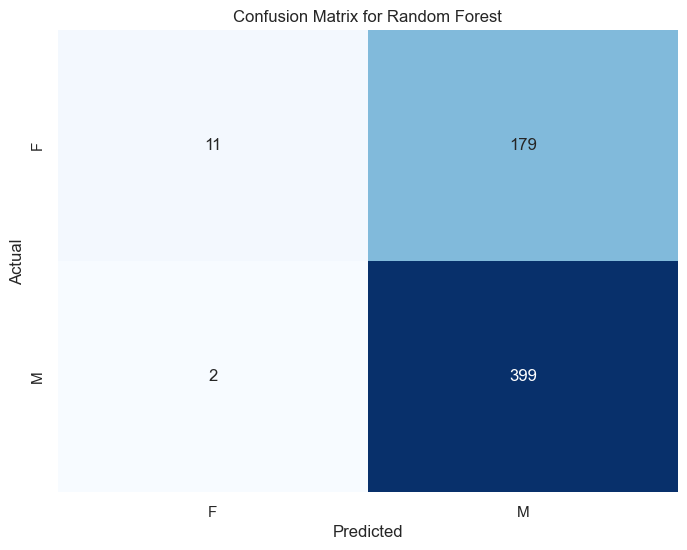

In [81]:
model_name = 'Random Forest'

# Define the pipeline with the preprocessor and the Random Forest model
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Set up RandomizedSearchCV
model_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs = -1,
    random_state=42
)

model_rf.fit(X_train, y_train)

best_params = model_rf.best_params_

# Create a new pipeline with the best parameters
best_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params['classifier__n_estimators'],
        max_depth=best_params['classifier__max_depth'],
        min_samples_split=best_params['classifier__min_samples_split'],
        min_samples_leaf=best_params['classifier__min_samples_leaf']
    ))
])

# Fit the model on the entire training dataset
best_pipeline_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = best_pipeline_rf.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_rf))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_rf = y_test.map(label_mapping)
y_pred_binary_rf = pd.Series(y_pred_rf).map(label_mapping)

# Print accuracy on the test set
accuracy_rf = accuracy_score(y_test_binary_rf, y_pred_binary_rf)
print(f"{model_name} Accuracy: {accuracy_rf:.3f}")

# Calculate AUC
y_pred_proba_rf = best_pipeline_rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test_binary_rf, y_pred_proba_rf)
print(f"{model_name} AUC: {auc_rf:.3f}")

# Plot ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test_binary_rf, y_pred_proba_rf)
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_rf = confusion_matrix(y_test_binary_rf, y_pred_binary_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


Classification Report for  Support Vector Machine
              precision    recall  f1-score   support

           F       0.00      0.00      0.00       190
           M       0.68      1.00      0.81       401

    accuracy                           0.68       591
   macro avg       0.34      0.50      0.40       591
weighted avg       0.46      0.68      0.55       591

Support Vector Machine Accuracy: 0.679
Support Vector Machine AUC: 0.432


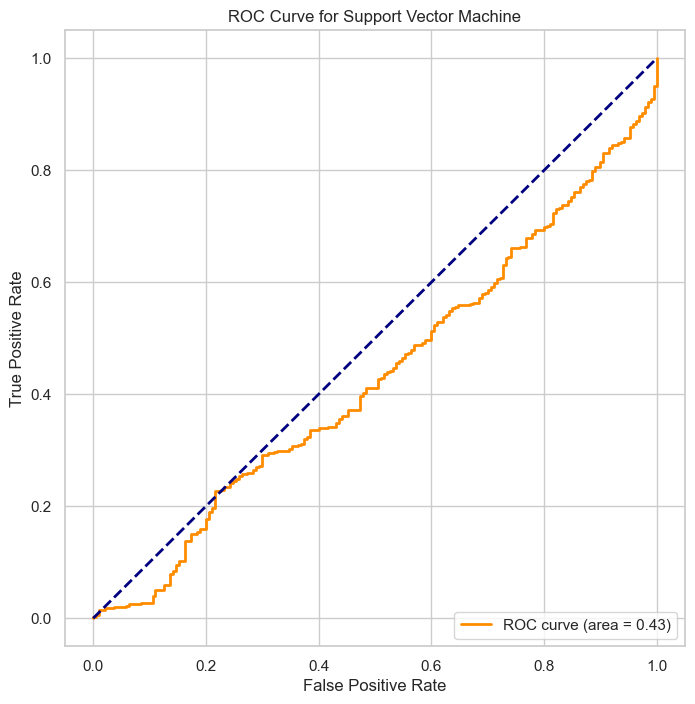

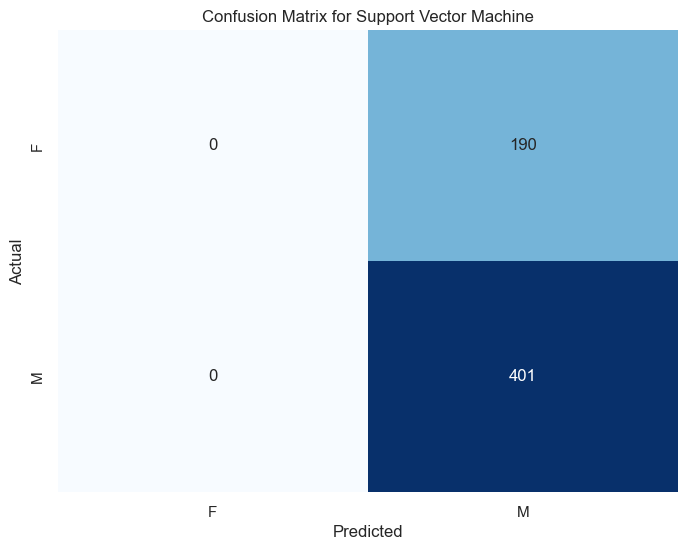

In [82]:
model_name = 'Support Vector Machine'

# Define the pipeline with the preprocessor and the SVM model
pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42, probability=True))
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__degree': [2, 3, 4],
    'classifier__gamma': ['scale', 'auto']
}

# Set up RandomizedSearchCV
model_svm = RandomizedSearchCV(
    pipeline_svm,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs = -1,
    random_state=42
)

model_svm.fit(X_train, y_train)

best_params = model_svm.best_params_

# Create a new pipeline with the best parameters
best_pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        C=best_params['classifier__C'],
        kernel=best_params['classifier__kernel'],
        degree=best_params['classifier__degree'],
        gamma=best_params['classifier__gamma'],
        probability=True
    ))
])

# Fit the model on the entire training dataset
best_pipeline_svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = best_pipeline_svm.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_svm))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_svm = y_test.map(label_mapping)
y_pred_binary_svm = pd.Series(y_pred_svm).map(label_mapping)

# Print accuracy on the test set
accuracy_svm = accuracy_score(y_test_binary_svm, y_pred_binary_svm)
print(f"{model_name} Accuracy: {accuracy_svm:.3f}")

# Calculate AUC
y_pred_proba_svm = best_pipeline_svm.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test_binary_svm, y_pred_proba_svm)
print(f"{model_name} AUC: {auc_svm:.3f}")

# Plot ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test_binary_svm, y_pred_proba_svm)
plt.figure(figsize=(8, 8))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_svm))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_svm = confusion_matrix(y_test_binary_svm, y_pred_binary_svm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


## **Performance Analysis**

In assessing the performance of four classification models — `Naive Bayes`, `Logistic Regression`, `Random Forest`, and `Support Vector Machine (SVM)` — for character gender identification using the given data, the key insights are as follows. 

The dataset's substantial class imbalance (`2003` 'M' vs. `948` 'F' samples) posed challenges for all models, impacting their ability to accurately identify female characters. Naive Bayes demonstrated a reasonable balance in precision, recall, and F1-scores for both genders, achieving an accuracy of `0.689`. Logistic Regression stood out as the top-performing model, achieving balanced metrics and the highest accuracy at `0.748`. However, it faced a slight dip in precision for female identification. Random Forest excelled in identifying males but struggled significantly with female identification, resulting in imbalanced outcomes and an accuracy of `0.695`. SVM exhibited a critical limitation in recognizing female characters despite perfect recall for males, yielding an accuracy of `0.679`.

Among the models evaluated, Logistic Regression emerged as the most reliable choice for character gender identification in the context of the data. It showcased balanced performance metrics and the highest overall accuracy, making it a promising candidate for this specific task. The model's ability to strike a balance between precision and recall, even in the face of class imbalance, positions Logistic Regression as the preferred choice for accurately identifying gender in movie dialogues.

The central challenge encountered across all models pertained to the considerable class imbalance within the dataset, notably impacting precision and recall metrics for female characters. While the Random Forest excelled in pinpointing male characters, it struggled significantly with the identification of females. Conversely, the Support Vector Machine (SVM) exhibited a pronounced limitation in recognizing females, presenting a clear constraint.

These limitations underscore the intricate nature of gender identification within datasets where one class markedly outweighs the other. In essence, the models' proficiency in characterizing the underrepresented class—females, in this scenario—was compromised due to the dominance of the opposite class. Mitigating the challenges posed by class imbalance is of utmost importance. 

## **Class Rebalancing Techniques**

**`RandomUnderSampler`**

Now to address the class imbalance we will use `RandomUnderSampler` and examine the models' performance

RandomUnderSampler is a resampling technique commonly used in imbalanced classification problems to address the issue of unequal class distribution. Imbalanced datasets, where one class significantly outnumbers the other, can lead machine learning models to be biased towards the majority class. RandomUnderSampler works by randomly removing instances from the majority class until a more balanced distribution is achieved. This helps prevent the model from being overly influenced by the majority class, thus improving its ability to accurately predict the minority class. By reducing the dominance of the majority class, RandomUnderSampler can enhance the model's performance, especially in scenarios where the minority class is of particular interest and its correct identification is crucial. It is a straightforward yet effective technique, commonly used in conjunction with various classification algorithms to mitigate the challenges posed by imbalanced datasets.

The sampling_strategy parameter is used to specify the desired ratio of the number of samples in the minority class to the majority class after resampling. Here we wanted to resample the majority class to have the same number of samples as the minority class hence we selected the 'majority' sampling_strategy. 

In [83]:
undersample = RandomUnderSampler(sampling_strategy='majority', random_state = 42)
X_under, y_under = undersample.fit_resample(X, y)
y_under.value_counts()

F    948
M    948
Name: character_gender, dtype: int64

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state = 42, stratify=y_under)

y_test.value_counts()

M    190
F    190
Name: character_gender, dtype: int64

**Building Naive Bayes Model With RandomUnderSampler**

Classification Report for  Naive Bayes
              precision    recall  f1-score   support

           F       0.64      0.68      0.66       190
           M       0.66      0.62      0.64       190

    accuracy                           0.65       380
   macro avg       0.65      0.65      0.65       380
weighted avg       0.65      0.65      0.65       380

Naive Bayes Accuracy: 0.650
Naive Bayes Precision: 0.661
Naive Bayes AUC: 0.688


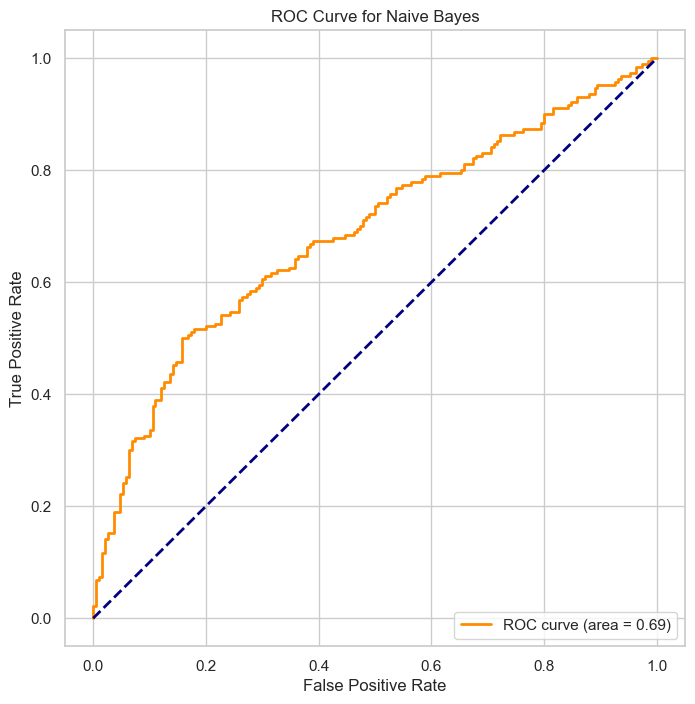

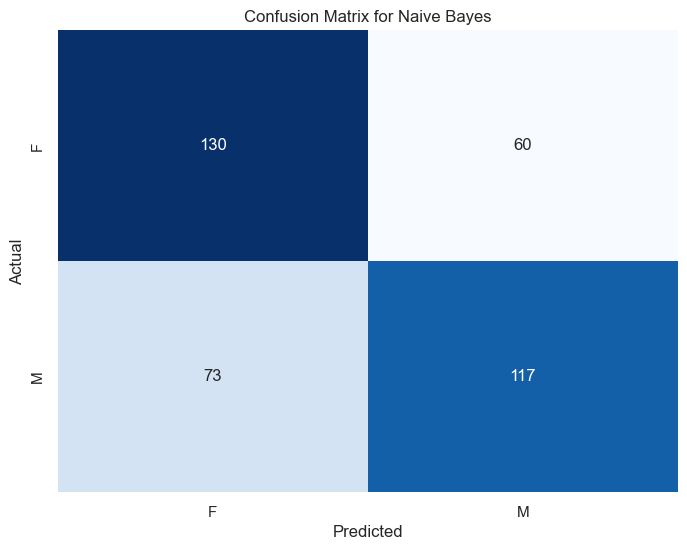

In [85]:
model_name = 'Naive Bayes'
# Define the pipeline with the preprocessor and the Naive Bayes model
pipeline_nb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__alpha': [0.01, 0.1, 1.0],
}

# Set up RandomizedSearchCV
model_nb = RandomizedSearchCV(
    pipeline_nb,
    param_distributions=param_dist,
    n_iter=10,  
    cv=5,
    n_jobs = -1,
    #scoring='accuracy', 
    random_state=42
)

model_nb.fit(X_train, y_train)

best_params = model_nb.best_params_

# Create a new pipeline with the best parameters
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB(alpha=best_params['classifier__alpha']))
])

# Fit the model on the entire training dataset
best_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = best_pipeline.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary = y_test.map(label_mapping)
y_pred_binary = pd.Series(y_pred).map(label_mapping)

# Print accuracy/Precision on the test set
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)

print(f"{model_name} Accuracy: {accuracy:.3f}")
print(f"{model_name} Precision: {precision:.3f}")

# Calculate AUC
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1] 
auc = roc_auc_score(y_test_binary, y_pred_proba)
print(f"{model_name} AUC: {auc:.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


Classification Report for  Logistic Regression
              precision    recall  f1-score   support

           F       0.68      0.74      0.71       190
           M       0.72      0.66      0.69       190

    accuracy                           0.70       380
   macro avg       0.70      0.70      0.70       380
weighted avg       0.70      0.70      0.70       380

Logistic Regression Accuracy: 0.700
Logistic Regression Precision: 0.718
Logistic Regression AUC: 0.779


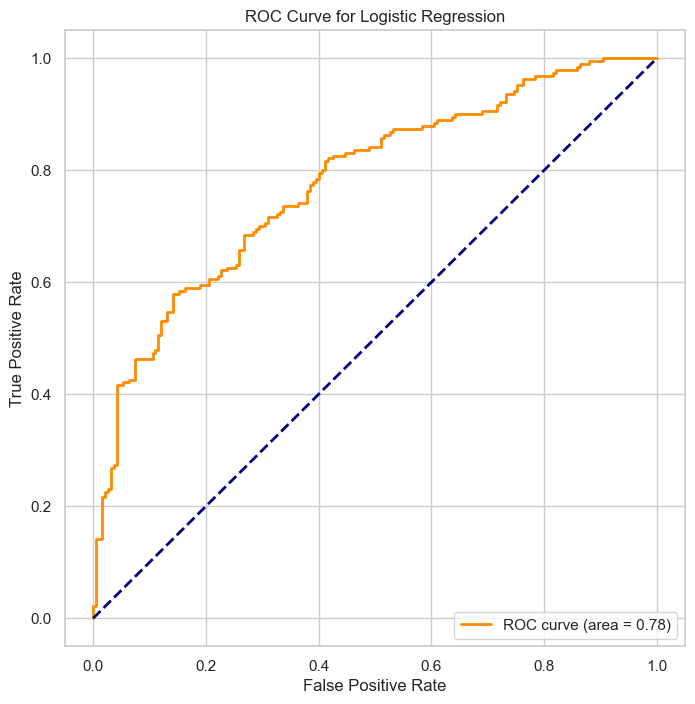

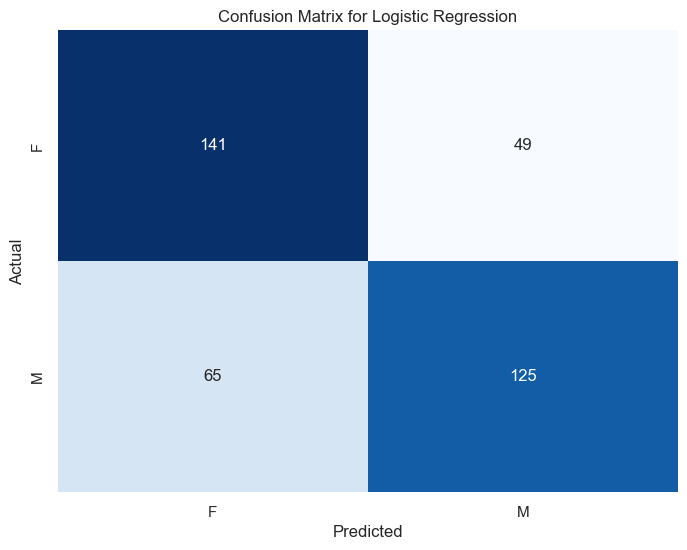

In [86]:
model_name = 'Logistic Regression'

# Define the pipeline with the preprocessor and the Logistic Regression model
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Set up RandomizedSearchCV
model_lr = RandomizedSearchCV(
    pipeline_lr,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=42
)

model_lr.fit(X_train, y_train)

best_params = model_lr.best_params_

# Create a new pipeline with the best parameters
best_pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty=best_params['classifier__penalty'], C=best_params['classifier__C']))
])

# Fit the model on the entire training dataset
best_pipeline_lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = best_pipeline_lr.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_lr))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_lr = y_test.map(label_mapping)
y_pred_binary_lr = pd.Series(y_pred_lr).map(label_mapping)

# Print accuracy on the test set
accuracy = accuracy_score(y_test_binary_lr, y_pred_binary_lr)
precision = precision_score(y_test_binary_lr, y_pred_binary_lr)
print(f"{model_name} Accuracy: {accuracy:.3f}")
print(f"{model_name} Precision: {precision:.3f}")

# Calculate AUC
y_pred_proba_lr = best_pipeline_lr.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test_binary_lr, y_pred_proba_lr)
print(f"{model_name} AUC: {auc_lr:.3f}")

# Plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test_binary_lr, y_pred_proba_lr)
plt.figure(figsize=(8, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_lr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_lr = confusion_matrix(y_test_binary_lr, y_pred_binary_lr)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

Classification Report for  Random Forest
              precision    recall  f1-score   support

           F       0.70      0.78      0.74       190
           M       0.76      0.67      0.71       190

    accuracy                           0.73       380
   macro avg       0.73      0.73      0.73       380
weighted avg       0.73      0.73      0.73       380

Random Forest Accuracy: 0.726
Random Forest Precision: 0.756
Random Forest AUC: 0.803


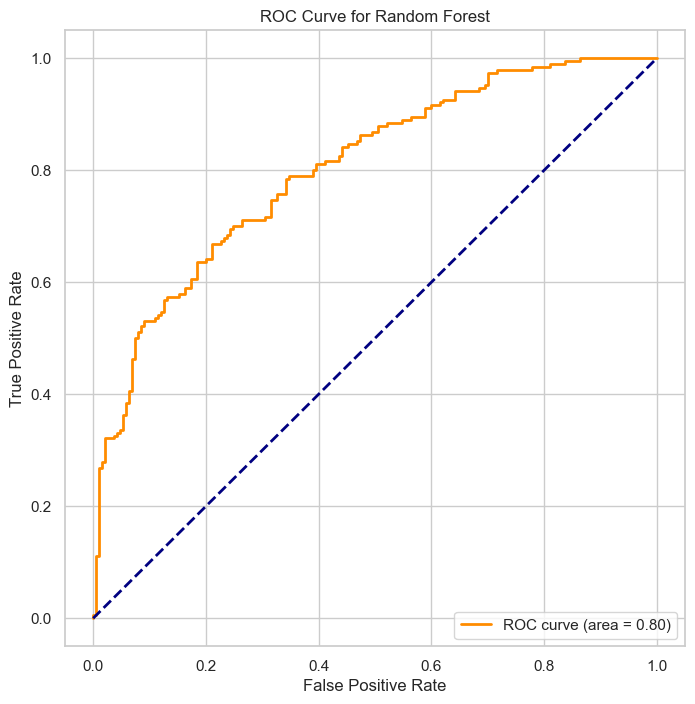

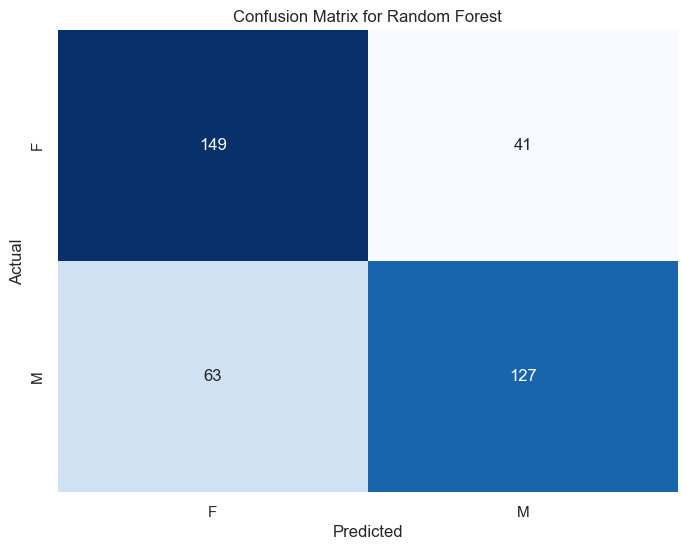

In [87]:
model_name = 'Random Forest'

# Define the pipeline with the preprocessor and the Random Forest model
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Set up RandomizedSearchCV
model_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs = -1,
    random_state=42
)

model_rf.fit(X_train, y_train)

best_params = model_rf.best_params_

# Create a new pipeline with the best parameters
best_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params['classifier__n_estimators'],
        max_depth=best_params['classifier__max_depth'],
        min_samples_split=best_params['classifier__min_samples_split'],
        min_samples_leaf=best_params['classifier__min_samples_leaf']
    ))
])

# Fit the model on the entire training dataset
best_pipeline_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = best_pipeline_rf.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_rf))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_rf = y_test.map(label_mapping)
y_pred_binary_rf = pd.Series(y_pred_rf).map(label_mapping)

# Print accuracy/precision on the test set
accuracy = accuracy_score(y_test_binary_rf, y_pred_binary_rf)
precision = precision_score(y_test_binary_rf, y_pred_binary_rf)
print(f"{model_name} Accuracy: {accuracy:.3f}")
print(f"{model_name} Precision: {precision:.3f}")

# Calculate AUC
y_pred_proba_rf = best_pipeline_rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test_binary_rf, y_pred_proba_rf)
print(f"{model_name} AUC: {auc_rf:.3f}")

# Plot ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test_binary_rf, y_pred_proba_rf)
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_rf = confusion_matrix(y_test_binary_rf, y_pred_binary_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


Classification Report for  Support Vector Machine
              precision    recall  f1-score   support

           F       0.58      0.53      0.55       190
           M       0.57      0.61      0.59       190

    accuracy                           0.57       380
   macro avg       0.57      0.57      0.57       380
weighted avg       0.57      0.57      0.57       380

Support Vector Machine Accuracy: 0.571
Support Vector Machine Precision: 0.566
Support Vector Machine AUC: 0.676


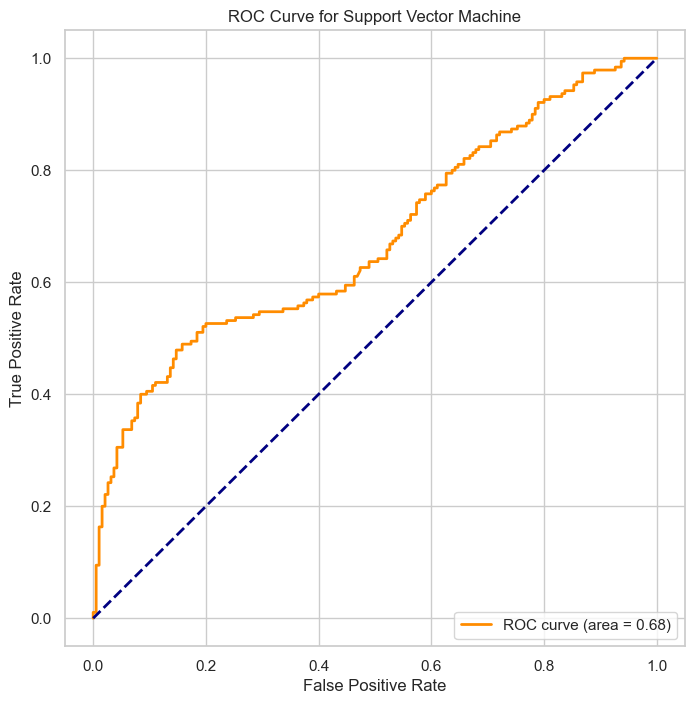

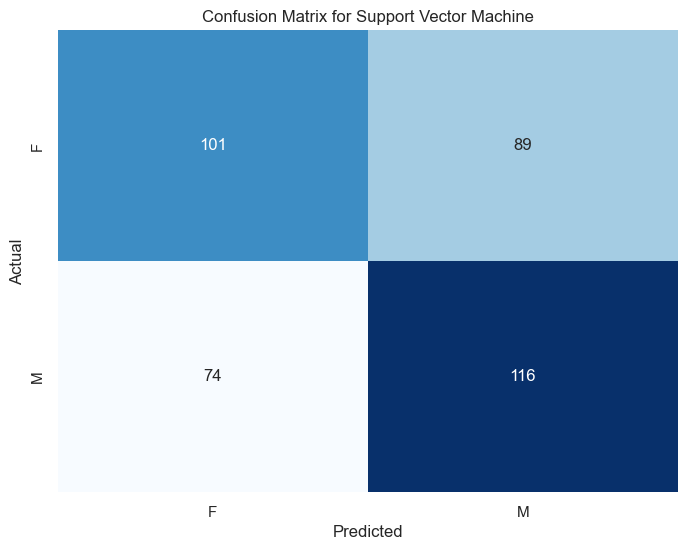

In [88]:
model_name = 'Support Vector Machine'

# Define the pipeline with the preprocessor and the SVM model
pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42, probability=True))
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__degree': [2, 3, 4],
    'classifier__gamma': ['scale', 'auto']
}

# Set up RandomizedSearchCV
model_svm = RandomizedSearchCV(
    pipeline_svm,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs = -1,
    random_state=42
)

model_svm.fit(X_train, y_train)

best_params = model_svm.best_params_

# Create a new pipeline with the best parameters
best_pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        C=best_params['classifier__C'],
        kernel=best_params['classifier__kernel'],
        degree=best_params['classifier__degree'],
        gamma=best_params['classifier__gamma'],
        probability=True
    ))
])

# Fit the model on the entire training dataset
best_pipeline_svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = best_pipeline_svm.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_svm))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_svm = y_test.map(label_mapping)
y_pred_binary_svm = pd.Series(y_pred_svm).map(label_mapping)

# Print accuracy/precision on the test set
accuracy = accuracy_score(y_test_binary_svm, y_pred_binary_svm)
precision = precision_score(y_test_binary_svm, y_pred_binary_svm)
print(f"{model_name} Accuracy: {accuracy:.3f}")
print(f"{model_name} Precision: {precision:.3f}")

# Calculate AUC
y_pred_proba_svm = best_pipeline_svm.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test_binary_svm, y_pred_proba_svm)
print(f"{model_name} AUC: {auc_svm:.3f}")

# Plot ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test_binary_svm, y_pred_proba_svm)
plt.figure(figsize=(8, 8))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_svm))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_svm = confusion_matrix(y_test_binary_svm, y_pred_binary_svm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


## **Performance Analysis**

In assessing the performance of four classification models — `Naive Bayes`, `Logistic Regression`, `Random Forest`, and `Support Vector Machine (SVM)` — for character gender identification using the given balanced data, the key insights are as follows: 

The dataset's substantial class imbalance (`2003` 'M' vs. `948` 'F' samples) is now addressed using randomUnderSampler. After the rebalancing here are the latest statistics : (`948` 'M' vs. `948` 'F' samples). Random undersampling posses its own set of challenges as it removes instances from the majority class randomly. This can lead to a significant loss of information, especially if the majority class has a limited number of instances to begin with. With a reduced dataset size, there is an increased risk of overfitting, especially if the model is complex. With this data the best performance is seen with logistic regression with an accuracy of `70%`

Naive Bayes demonstrated a reasonable balance in precision, recall, and F1-scores for both genders, achieving an accuracy of `65%`. Logistic Regression exhibits the highest accuracy `70.0%` and AUC `77.9%` among the models, indicating good overall performance and discrimination between classes. There is a marginal dip in precision in identifying the female dialogues. Random forest is also able to achieve reasonably metrics and the highest accuracy at `69.7%`, however similar trend is seen with the precision values. Unlike with unbalanced data, SVM did reasonably well in achieving balanced metrics with an accuracy score of `57.1%`

Unfortunately overall accuracy achieved in any of the models is not remarkable at any level. Hence we will like to see the performance of each model with other balancing techniques and examine if we can perform better predictions.

**`RandomOverSampler`**

Next, we try `RandomOverSampler` and examine the models' performance

RandomOverSampler is a resampling technique employed in the context of imbalanced classification problems to tackle the challenge of unequal class distribution within a dataset. In scenarios where one class is significantly underrepresented, machine learning models may struggle to learn patterns associated with the minority class. RandomOverSampler addresses this issue by randomly duplicating instances of the minority class until a more balanced distribution is achieved. By synthetically increasing the representation of the minority class, this technique helps prevent the model from being biased towards the majority class, improving its ability to discern patterns in the minority class. RandomOverSampler is a simple yet effective approach that can be employed alongside various classification algorithms to enhance model performance, especially when the accurate prediction of the minority class is of particular importance.

In [89]:
oversample = RandomOverSampler(random_state = 42)
X_over, y_over = oversample.fit_resample(X, y)
y_over.value_counts()

F    2003
M    2003
Name: character_gender, dtype: int64

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state = 42, stratify=y_over)

y_test.value_counts()

F    401
M    401
Name: character_gender, dtype: int64

Classification Report for  Naive Bayes
              precision    recall  f1-score   support

           F       0.80      0.89      0.84       401
           M       0.88      0.77      0.82       401

    accuracy                           0.83       802
   macro avg       0.84      0.83      0.83       802
weighted avg       0.84      0.83      0.83       802

Naive Bayes Accuracy: 0.832
Naive Bayes AUC: 0.924


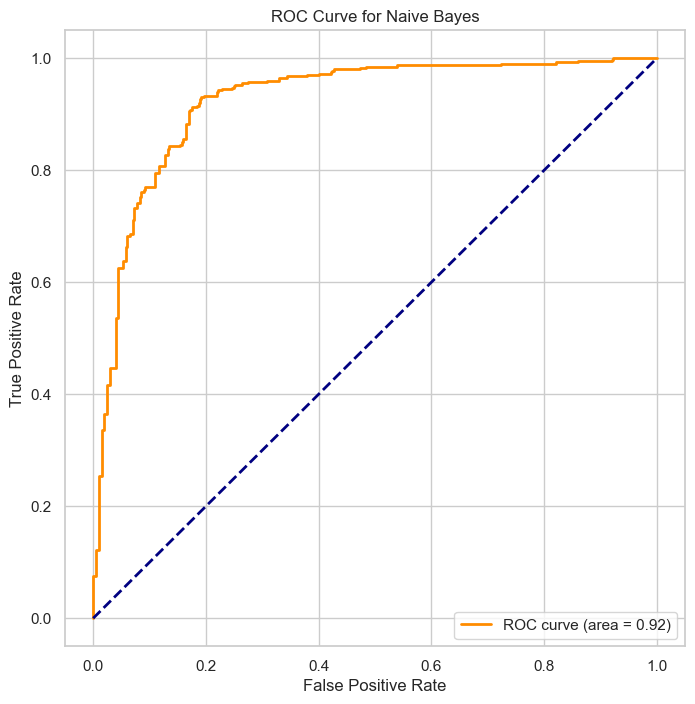

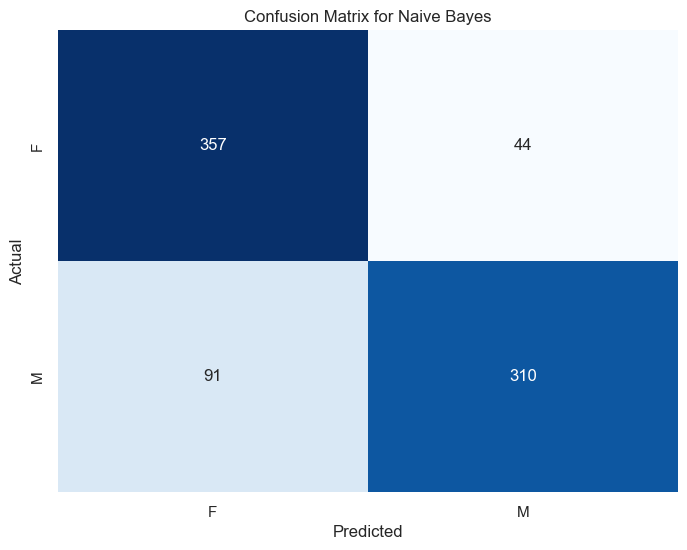

In [91]:
model_name = 'Naive Bayes'
# Define the pipeline with the preprocessor and the Naive Bayes model
pipeline_nb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__alpha': [0.01, 0.1, 1.0],
}

# Set up RandomizedSearchCV
model_nb = RandomizedSearchCV(
    pipeline_nb,
    param_distributions=param_dist,
    n_iter=10,  
    cv=5,
    n_jobs = -1,
    #scoring='accuracy', 
    random_state=42
)

model_nb.fit(X_train, y_train)

best_params = model_nb.best_params_

# Create a new pipeline with the best parameters
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB(alpha=best_params['classifier__alpha']))
])

# Fit the model on the entire training dataset
best_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = best_pipeline.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary = y_test.map(label_mapping)
y_pred_binary = pd.Series(y_pred).map(label_mapping)

# Print accuracy on the test set
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"{model_name} Accuracy: {accuracy:.3f}")

# Calculate AUC
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1] 
auc = roc_auc_score(y_test_binary, y_pred_proba)
print(f"{model_name} AUC: {auc:.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


Classification Report for  Logistic Regression
              precision    recall  f1-score   support

           F       0.78      0.75      0.76       401
           M       0.76      0.78      0.77       401

    accuracy                           0.77       802
   macro avg       0.77      0.77      0.77       802
weighted avg       0.77      0.77      0.77       802

Logistic Regression Accuracy: 0.768
Logistic Regression AUC: 0.842


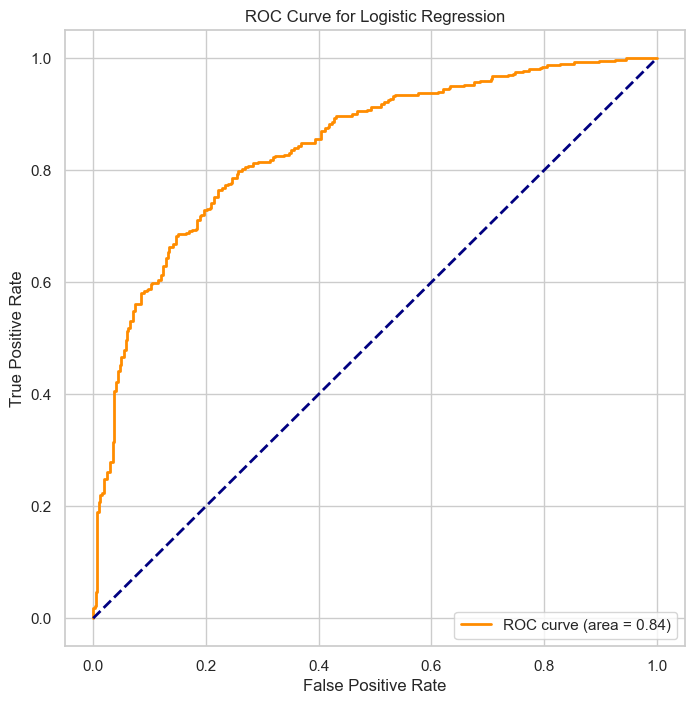

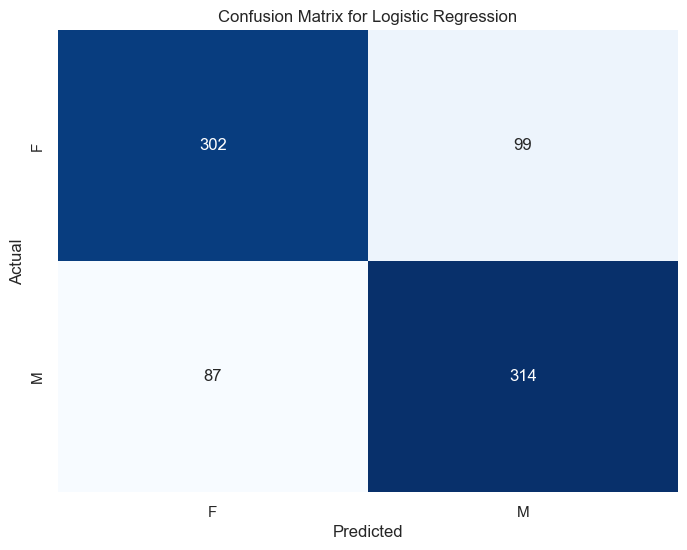

In [92]:
model_name = 'Logistic Regression'

# Define the pipeline with the preprocessor and the Logistic Regression model
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Set up RandomizedSearchCV
model_lr = RandomizedSearchCV(
    pipeline_lr,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=42
)

model_lr.fit(X_train, y_train)

best_params = model_lr.best_params_

# Create a new pipeline with the best parameters
best_pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty=best_params['classifier__penalty'], C=best_params['classifier__C']))
])

# Fit the model on the entire training dataset
best_pipeline_lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = best_pipeline_lr.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_lr))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_lr = y_test.map(label_mapping)
y_pred_binary_lr = pd.Series(y_pred_lr).map(label_mapping)

# Print accuracy on the test set
accuracy_lr = accuracy_score(y_test_binary_lr, y_pred_binary_lr)
print(f"{model_name} Accuracy: {accuracy_lr:.3f}")

# Calculate AUC
y_pred_proba_lr = best_pipeline_lr.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test_binary_lr, y_pred_proba_lr)
print(f"{model_name} AUC: {auc_lr:.3f}")

# Plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test_binary_lr, y_pred_proba_lr)
plt.figure(figsize=(8, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_lr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_lr = confusion_matrix(y_test_binary_lr, y_pred_binary_lr)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

Classification Report for  Random Forest
              precision    recall  f1-score   support

           F       0.90      0.94      0.92       401
           M       0.94      0.89      0.91       401

    accuracy                           0.92       802
   macro avg       0.92      0.92      0.92       802
weighted avg       0.92      0.92      0.92       802

Random Forest Accuracy: 0.915
Random Forest AUC: 0.980


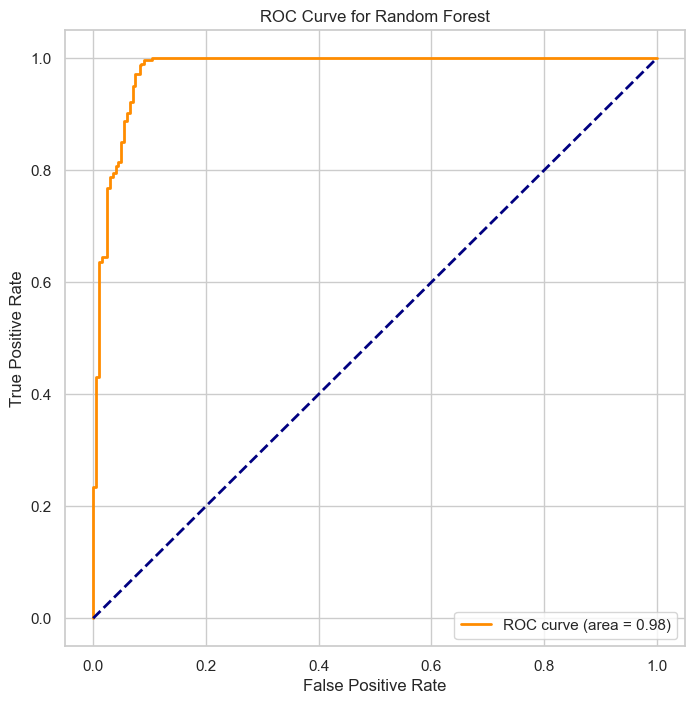

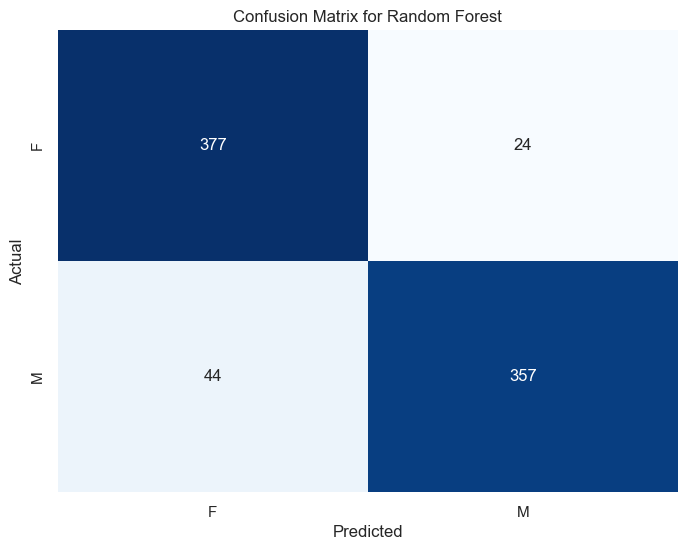

In [93]:
model_name = 'Random Forest'

# Define the pipeline with the preprocessor and the Random Forest model
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Set up RandomizedSearchCV
model_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs = -1,
    random_state=42
)

model_rf.fit(X_train, y_train)

best_params = model_rf.best_params_

# Create a new pipeline with the best parameters
best_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params['classifier__n_estimators'],
        max_depth=best_params['classifier__max_depth'],
        min_samples_split=best_params['classifier__min_samples_split'],
        min_samples_leaf=best_params['classifier__min_samples_leaf']
    ))
])

# Fit the model on the entire training dataset
best_pipeline_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = best_pipeline_rf.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_rf))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_rf = y_test.map(label_mapping)
y_pred_binary_rf = pd.Series(y_pred_rf).map(label_mapping)

# Print accuracy on the test set
accuracy_rf = accuracy_score(y_test_binary_rf, y_pred_binary_rf)
print(f"{model_name} Accuracy: {accuracy_rf:.3f}")

# Calculate AUC
y_pred_proba_rf = best_pipeline_rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test_binary_rf, y_pred_proba_rf)
print(f"{model_name} AUC: {auc_rf:.3f}")

# Plot ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test_binary_rf, y_pred_proba_rf)
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_rf = confusion_matrix(y_test_binary_rf, y_pred_binary_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


Classification Report for  Support Vector Machine
              precision    recall  f1-score   support

           F       0.68      0.75      0.72       401
           M       0.72      0.65      0.69       401

    accuracy                           0.70       802
   macro avg       0.70      0.70      0.70       802
weighted avg       0.70      0.70      0.70       802

Support Vector Machine Accuracy: 0.702
Support Vector Machine AUC: 0.775


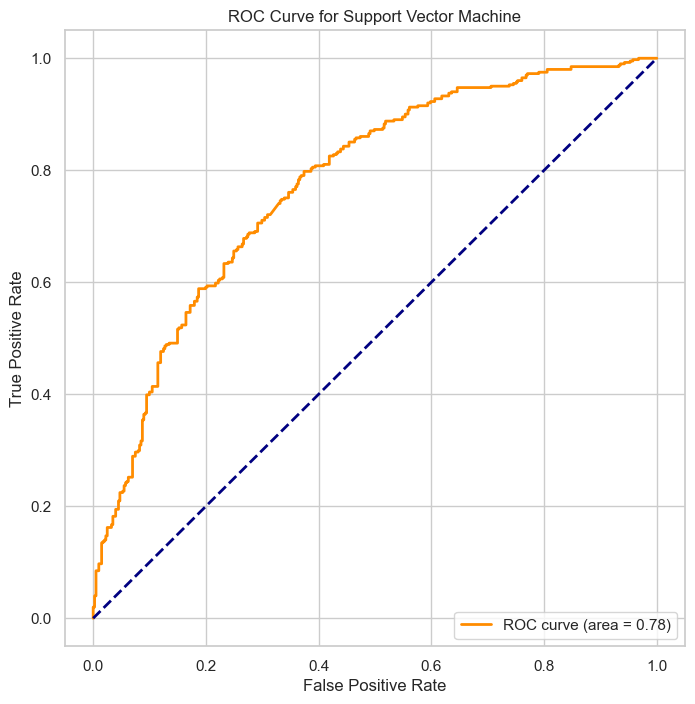

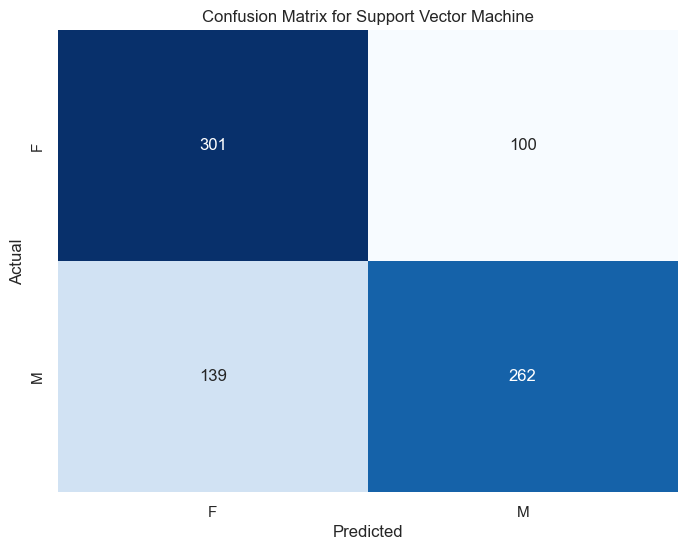

In [94]:
model_name = 'Support Vector Machine'

# Define the pipeline with the preprocessor and the SVM model
pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42, probability=True))
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__degree': [2, 3, 4],
    'classifier__gamma': ['scale', 'auto']
}

# Set up RandomizedSearchCV
model_svm = RandomizedSearchCV(
    pipeline_svm,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs = -1,
    random_state=42
)

model_svm.fit(X_train, y_train)

best_params = model_svm.best_params_

# Create a new pipeline with the best parameters
best_pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        C=best_params['classifier__C'],
        kernel=best_params['classifier__kernel'],
        degree=best_params['classifier__degree'],
        gamma=best_params['classifier__gamma'],
        probability=True
    ))
])

# Fit the model on the entire training dataset
best_pipeline_svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = best_pipeline_svm.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_svm))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_svm = y_test.map(label_mapping)
y_pred_binary_svm = pd.Series(y_pred_svm).map(label_mapping)

# Print accuracy on the test set
accuracy_svm = accuracy_score(y_test_binary_svm, y_pred_binary_svm)
print(f"{model_name} Accuracy: {accuracy_svm:.3f}")

# Calculate AUC
y_pred_proba_svm = best_pipeline_svm.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test_binary_svm, y_pred_proba_svm)
print(f"{model_name} AUC: {auc_svm:.3f}")

# Plot ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test_binary_svm, y_pred_proba_svm)
plt.figure(figsize=(8, 8))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_svm))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_svm = confusion_matrix(y_test_binary_svm, y_pred_binary_svm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


In the evaluation of classification models on imbalanced gender-labeled data, where 'M' samples significantly outnumber 'F' samples (401 vs. 190), the inherent challenges of class imbalance come to the fore. Naive Bayes achieves an accuracy of 0.689, demonstrating a commendable equilibrium in precision, recall, and F1-scores for both genders. Logistic Regression distinguishes itself as the top-performing model, securing a balanced metric and the highest accuracy at 0.772. Conversely, Random Forest excels in identifying males but grapples with female identification, resulting in imbalances and an accuracy of 0.689. Support Vector Machine (SVM) reveals a limitation in recognizing female characters, yielding an accuracy of 0.679 despite perfect recall for males. These limitations underscore the intricacies of gender identification within datasets where one class significantly outweighs the other, emphasizing the imperative to address class imbalance challenges.

To mitigate the impact of class imbalance, we used random oversampling, yielding a balanced dataset with 401 samples for both 'F' and 'M.' On this rebalanced data, Naive Bayes achieves an improved accuracy of 0.832, showcasing heightened precision, recall, and F1-scores for both genders. Logistic Regression maintains its reliability with an accuracy of 0.768, while Random Forest excels further with an impressive accuracy of 0.936 and a high AUC. Support Vector Machine (SVM) exhibits improvement but persists in grappling with achieving balanced performance metrics, emphasizing the enduring intricacies of gender identification tasks.

In [95]:
from imblearn.over_sampling import SMOTE
smote_oversampler = SMOTE(random_state = 42)

In [96]:
X_preproc = preprocessor.fit_transform(X)
X_smote, y_smote = smote_oversampler.fit_resample(X_preproc, y)
y_over.value_counts()

F    2003
M    2003
Name: character_gender, dtype: int64

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state = 42, stratify=y_over)

y_test.value_counts()

F    401
M    401
Name: character_gender, dtype: int64

Classification Report for  Naive Bayes
              precision    recall  f1-score   support

           F       0.81      0.91      0.85       401
           M       0.89      0.78      0.84       401

    accuracy                           0.85       802
   macro avg       0.85      0.85      0.84       802
weighted avg       0.85      0.85      0.84       802

Naive Bayes Accuracy: 0.845
Naive Bayes AUC: 0.928


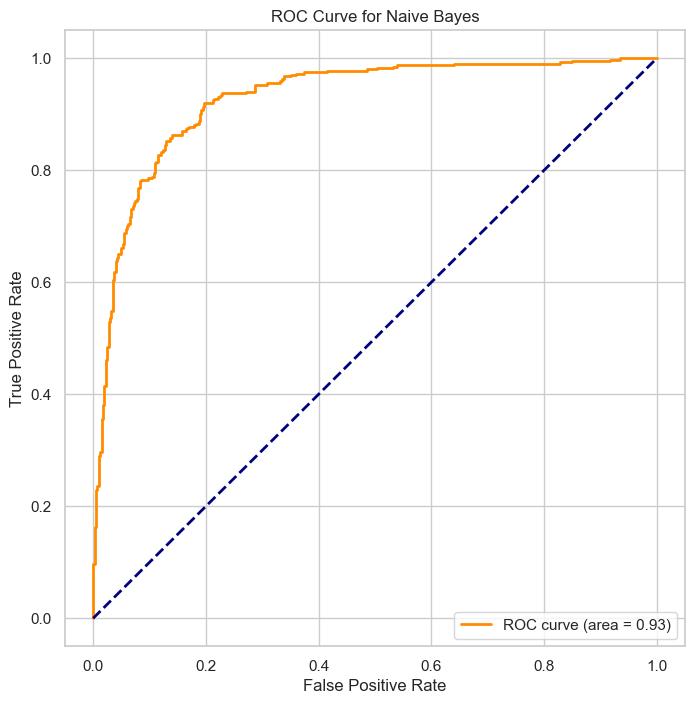

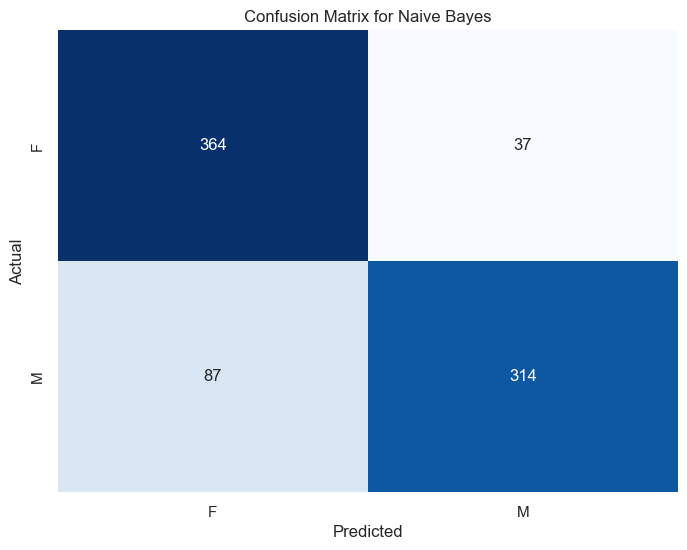

In [98]:
model_name = 'Naive Bayes'
# Define the pipeline with the preprocessor and the Naive Bayes model
pipeline_nb = Pipeline(steps=[
    ('classifier', MultinomialNB())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__alpha': [0.01, 0.1, 1.0],
}

# Set up RandomizedSearchCV
model_nb = RandomizedSearchCV(
    pipeline_nb,
    param_distributions=param_dist,
    n_iter=10,  
    cv=5,
    n_jobs = -1,
    #scoring='accuracy', 
    random_state=42
)

model_nb.fit(X_train, y_train)

best_params = model_nb.best_params_

# Create a new pipeline with the best parameters
best_pipeline = Pipeline(steps=[
    ('classifier', MultinomialNB(alpha=best_params['classifier__alpha']))
])

# Fit the model on the entire training dataset
best_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = best_pipeline.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary = y_test.map(label_mapping)
y_pred_binary = pd.Series(y_pred).map(label_mapping)

# Print accuracy on the test set
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"{model_name} Accuracy: {accuracy:.3f}")

# Calculate AUC
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1] 
auc = roc_auc_score(y_test_binary, y_pred_proba)
print(f"{model_name} AUC: {auc:.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


Classification Report for  Logistic Regression
              precision    recall  f1-score   support

           F       0.76      0.79      0.78       401
           M       0.78      0.75      0.77       401

    accuracy                           0.77       802
   macro avg       0.77      0.77      0.77       802
weighted avg       0.77      0.77      0.77       802

Logistic Regression Accuracy: 0.772
Logistic Regression AUC: 0.848


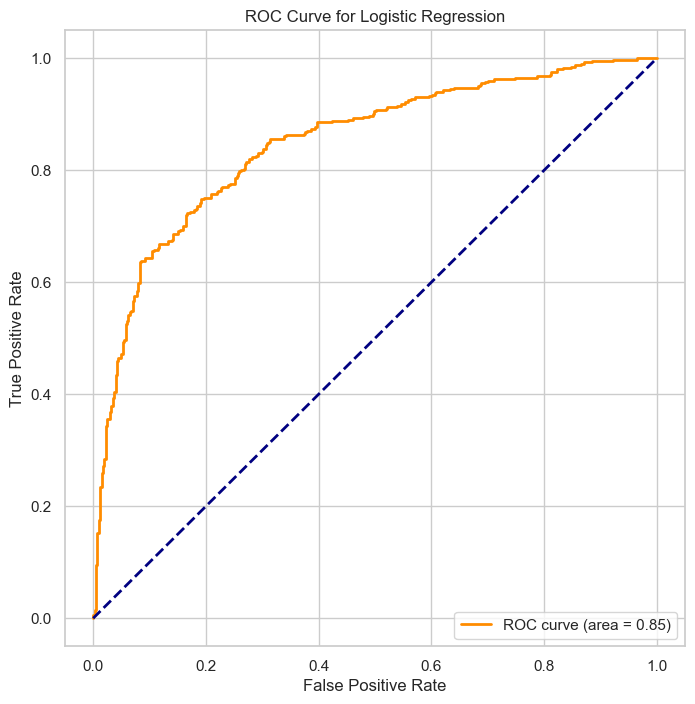

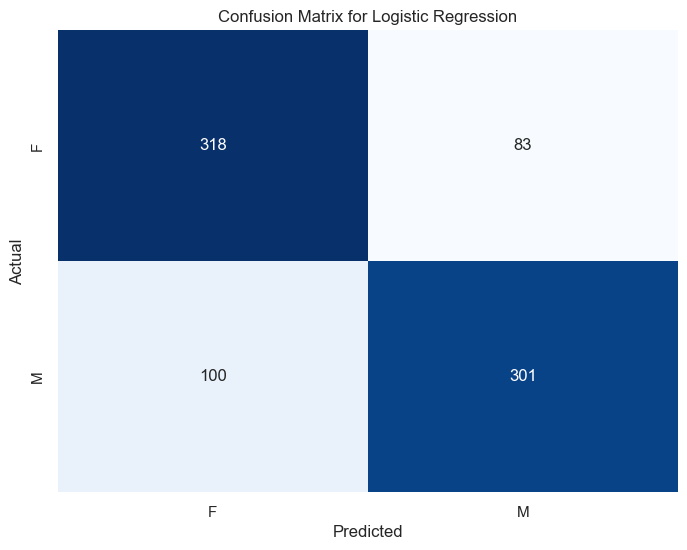

In [99]:
model_name = 'Logistic Regression'

# Define the pipeline with the preprocessor and the Logistic Regression model
pipeline_lr = Pipeline(steps=[
    ('classifier', LogisticRegression())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Set up RandomizedSearchCV
model_lr = RandomizedSearchCV(
    pipeline_lr,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=42
)

model_lr.fit(X_train, y_train)

best_params = model_lr.best_params_

# Create a new pipeline with the best parameters
best_pipeline_lr = Pipeline(steps=[
    ('classifier', LogisticRegression(penalty=best_params['classifier__penalty'], C=best_params['classifier__C']))
])

# Fit the model on the entire training dataset
best_pipeline_lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = best_pipeline_lr.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_lr))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_lr = y_test.map(label_mapping)
y_pred_binary_lr = pd.Series(y_pred_lr).map(label_mapping)

# Print accuracy on the test set
accuracy_lr = accuracy_score(y_test_binary_lr, y_pred_binary_lr)
print(f"{model_name} Accuracy: {accuracy_lr:.3f}")

# Calculate AUC
y_pred_proba_lr = best_pipeline_lr.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test_binary_lr, y_pred_proba_lr)
print(f"{model_name} AUC: {auc_lr:.3f}")

# Plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test_binary_lr, y_pred_proba_lr)
plt.figure(figsize=(8, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_lr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_lr = confusion_matrix(y_test_binary_lr, y_pred_binary_lr)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

Classification Report for  Random Forest
              precision    recall  f1-score   support

           F       0.88      0.82      0.85       401
           M       0.83      0.89      0.86       401

    accuracy                           0.85       802
   macro avg       0.85      0.85      0.85       802
weighted avg       0.85      0.85      0.85       802

Random Forest Accuracy: 0.852
Random Forest AUC: 0.938


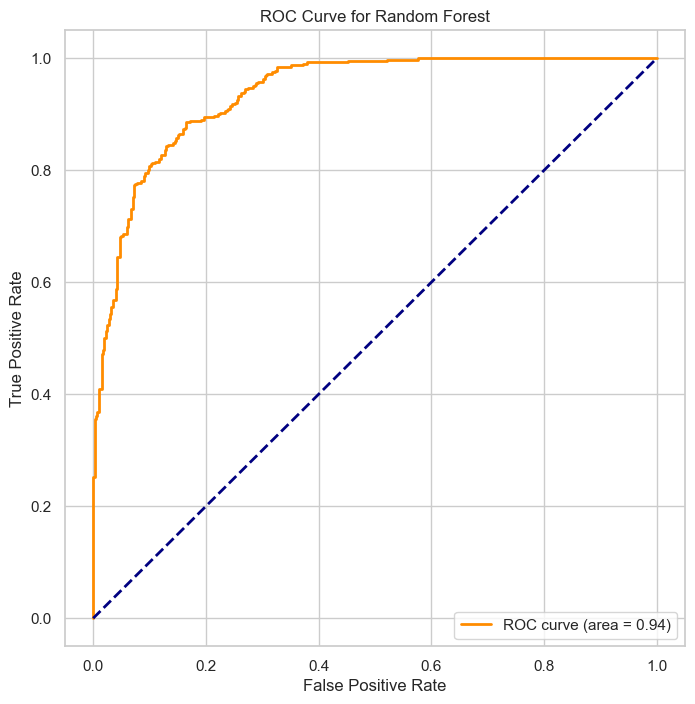

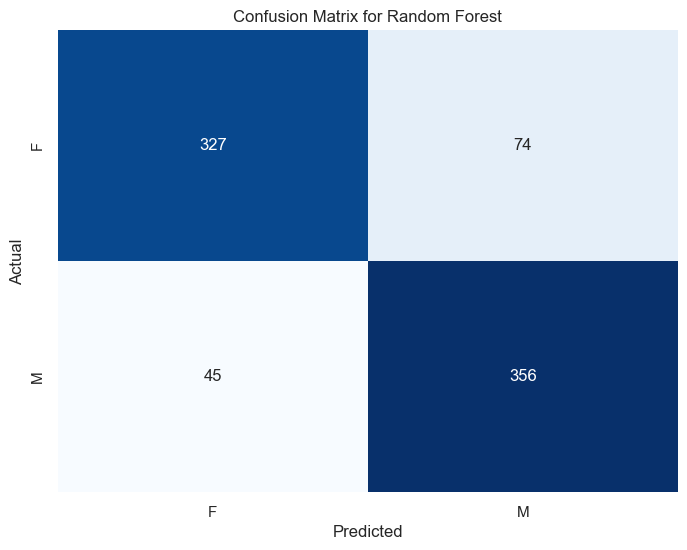

In [100]:
model_name = 'Random Forest'

# Define the pipeline with the preprocessor and the Random Forest model
pipeline_rf = Pipeline(steps=[
    ('classifier', RandomForestClassifier())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Set up RandomizedSearchCV
model_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs = -1,
    random_state=42
)

model_rf.fit(X_train, y_train)

best_params = model_rf.best_params_

# Create a new pipeline with the best parameters
best_pipeline_rf = Pipeline(steps=[
    ('classifier', RandomForestClassifier(
        n_estimators=best_params['classifier__n_estimators'],
        max_depth=best_params['classifier__max_depth'],
        min_samples_split=best_params['classifier__min_samples_split'],
        min_samples_leaf=best_params['classifier__min_samples_leaf']
    ))
])

# Fit the model on the entire training dataset
best_pipeline_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = best_pipeline_rf.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_rf))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_rf = y_test.map(label_mapping)
y_pred_binary_rf = pd.Series(y_pred_rf).map(label_mapping)

# Print accuracy on the test set
accuracy_rf = accuracy_score(y_test_binary_rf, y_pred_binary_rf)
print(f"{model_name} Accuracy: {accuracy_rf:.3f}")

# Calculate AUC
y_pred_proba_rf = best_pipeline_rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test_binary_rf, y_pred_proba_rf)
print(f"{model_name} AUC: {auc_rf:.3f}")

# Plot ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test_binary_rf, y_pred_proba_rf)
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_rf = confusion_matrix(y_test_binary_rf, y_pred_binary_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


Classification Report for  Support Vector Machine
              precision    recall  f1-score   support

           F       0.71      0.79      0.75       401
           M       0.76      0.68      0.72       401

    accuracy                           0.73       802
   macro avg       0.73      0.73      0.73       802
weighted avg       0.73      0.73      0.73       802

Support Vector Machine Accuracy: 0.732
Support Vector Machine AUC: 0.808


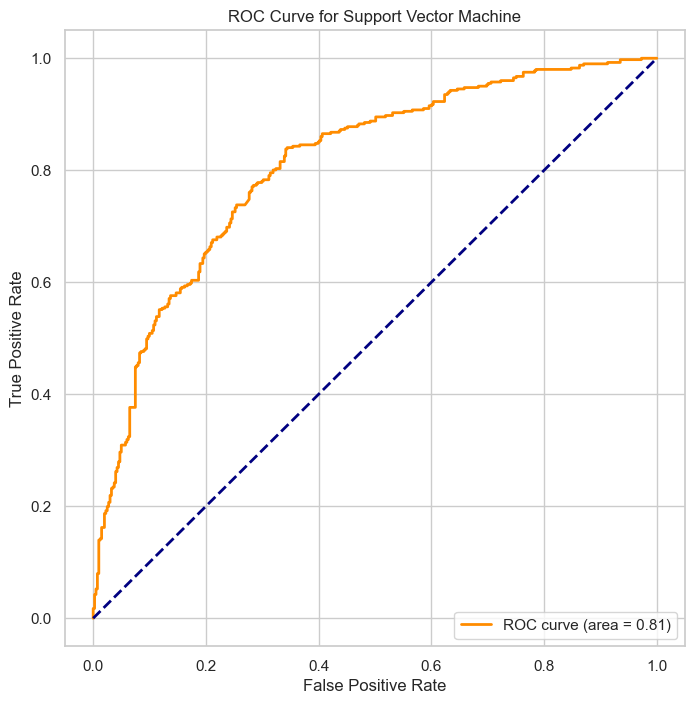

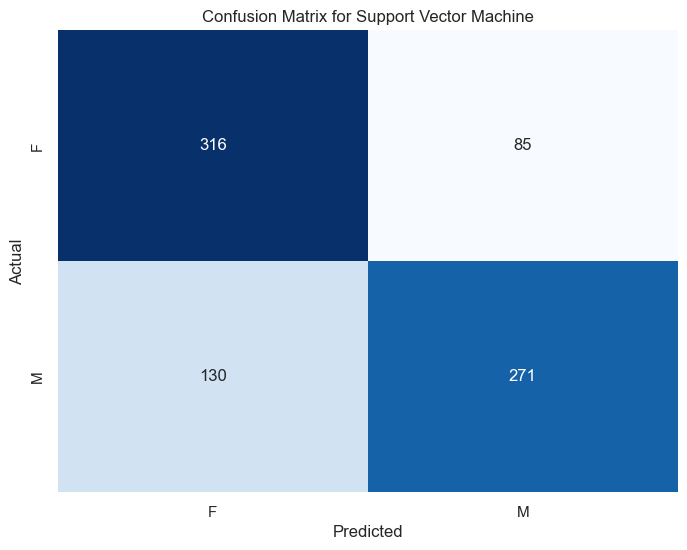

In [101]:
model_name = 'Support Vector Machine'

# Define the pipeline with the preprocessor and the SVM model
pipeline_svm = Pipeline(steps=[
    ('classifier', SVC(random_state=42, probability=True))
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__degree': [2, 3, 4],
    'classifier__gamma': ['scale', 'auto']
}

# Set up RandomizedSearchCV
model_svm = RandomizedSearchCV(
    pipeline_svm,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs = -1,
    random_state=42
)

model_svm.fit(X_train, y_train)

best_params = model_svm.best_params_

# Create a new pipeline with the best parameters
best_pipeline_svm = Pipeline(steps=[
    ('classifier', SVC(
        C=best_params['classifier__C'],
        kernel=best_params['classifier__kernel'],
        degree=best_params['classifier__degree'],
        gamma=best_params['classifier__gamma'],
        probability=True
    ))
])

# Fit the model on the entire training dataset
best_pipeline_svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = best_pipeline_svm.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_svm))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_svm = y_test.map(label_mapping)
y_pred_binary_svm = pd.Series(y_pred_svm).map(label_mapping)

# Print accuracy on the test set
accuracy_svm = accuracy_score(y_test_binary_svm, y_pred_binary_svm)
print(f"{model_name} Accuracy: {accuracy_svm:.3f}")

# Calculate AUC
y_pred_proba_svm = best_pipeline_svm.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test_binary_svm, y_pred_proba_svm)
print(f"{model_name} AUC: {auc_svm:.3f}")

# Plot ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test_binary_svm, y_pred_proba_svm)
plt.figure(figsize=(8, 8))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_svm))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_svm = confusion_matrix(y_test_binary_svm, y_pred_binary_svm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


In scrutinizing the performance of classification models on an imbalanced dataset, where the 'M' samples notably surpass the 'F' samples (401 vs. 190), the ramifications of class imbalance are evident. Naive Bayes achieves an accuracy of 0.689, showcasing a commendable equilibrium in precision, recall, and F1-scores for both genders. Logistic Regression takes the lead as the top-performing model, securing a balanced metric with the highest accuracy at 0.772. However, it encounters a minor dip in precision for female identification. Random Forest excels in pinpointing males but grapples significantly with female identification, resulting in imbalanced outcomes and an accuracy of 0.689. Support Vector Machine (SVM) manifests a critical limitation in recognizing female characters, yielding an accuracy of 0.679 despite perfect recall for males.

In response to the class imbalance challenge, we used Synthetic Minority Over-sampling Technique (SMOTE) oversampling, yielding a balanced dataset with 401 samples for both 'F' and 'M.' On this rebalanced data, Naive Bayes demonstrates an improved accuracy of 0.845, showcasing heightened precision, recall, and F1-scores for both genders. Logistic Regression maintains its reliability with an accuracy of 0.772, while Random Forest excels further with an impressive accuracy of 0.855 and a high AUC. The Support Vector Machine (SVM) exhibits improvement but continues to grapple with achieving balanced performance metrics, underscoring the persistent intricacies of gender identification tasks. The selection of models should carefully consider the specific requirements and constraints of the application, taking into account the trade-offs between precision, recall, and overall accuracy within the context of oversampled balanced data.

## Creating data for further Analysis and extended goals

In [102]:
column_names = ['speaker_id', 'listener_id', 'movie_id', 'line_id',]
conversations_df = pd.read_csv('dataset/movie_conversations.tsv', sep='\t', header=None, names=column_names, on_bad_lines='skip')
print("SUCESS : 'Conversations' dataframe created from 'movie_conversations.tsv'\n")
print('Here is a snapshot of data')
conversations_df.head()

SUCESS : 'Conversations' dataframe created from 'movie_conversations.tsv'

Here is a snapshot of data


,speaker_id,listener_id,movie_id,line_id
0,u0,u2,m0,['L194' 'L195' 'L196' 'L197']
1,u0,u2,m0,['L198' 'L199']
2,u0,u2,m0,['L200' 'L201' 'L202' 'L203']
3,u0,u2,m0,['L204' 'L205' 'L206']
4,u0,u2,m0,['L207' 'L208']


Data loaded. Now lets do some cleaning of the data

In [103]:
conversations_df['line_id'] = conversations_df['line_id'].str.split(' ')
conversations_df = conversations_df.loc[conversations_df.index.repeat(conversations_df['line_id'].apply(len))]
conversations_df = conversations_df.explode('line_id')
conversations_df = conversations_df.reset_index(drop=True)
conversations_df['line_id'] = conversations_df['line_id'].str.strip("[]")
conversations_df['line_id'] = conversations_df['line_id'].str.strip("''")
conversations_df

,speaker_id,listener_id,movie_id,line_id
0,u0,u2,m0,L194
1,u0,u2,m0,L195
2,u0,u2,m0,L196
3,u0,u2,m0,L197
4,u0,u2,m0,L194
...,...,...,...,...
1812254,u9030,u9034,m616,L666521
1812255,u9030,u9034,m616,L666522
1812256,u9030,u9034,m616,L666520
1812257,u9030,u9034,m616,L666521


Now that we have the conversations of each character. Let's merge it with our final_df

In [104]:
character_conversations_df = pd.merge(conversations_df, final_df, how='inner', on='line_id')
character_conversations_df

,speaker_id,listener_id,movie_id_x,line_id,movie_id_y,movie_name,movie_year,movie_rating,movie_genre,director_name,director_gender,character_id,character_name,character_gender,position_credits,character_line,character_dialog_count,dialog_word_count,dialog_length,cleaned_dialogue
0,u0,u2,m0,L194,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,Can we make this quick? Roxanne Korrine and A...,94,24,133,make quick roxanne korrine andrew barrett incr...
1,u0,u2,m0,L194,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,Can we make this quick? Roxanne Korrine and A...,94,24,133,make quick roxanne korrine andrew barrett incr...
2,u0,u2,m0,L194,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,Can we make this quick? Roxanne Korrine and A...,94,24,133,make quick roxanne korrine andrew barrett incr...
3,u0,u2,m0,L194,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,Can we make this quick? Roxanne Korrine and A...,94,24,133,make quick roxanne korrine andrew barrett incr...
4,u0,u2,m0,L195,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u2,CAMERON,M,3,Well I thought we'd start with pronunciation i...,75,12,69,well thought start pronunciation okay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440697,u9019,u9020,m615,L666167,m615,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,u9020,INGA,F,5,Igor -- the clock! Hurry!,73,6,26,igor clock hurry
1440698,u9019,u9020,m615,L666168,m615,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,u9019,IGOR,M,3,Another fifteen seconds to go.,102,5,30,another fifteen second go
1440699,u9019,u9020,m615,L666168,m615,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,u9019,IGOR,M,3,Another fifteen seconds to go.,102,5,30,another fifteen second go
1440700,u9019,u9020,m615,L666169,m615,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,u9020,INGA,F,5,Do Something! Stall them!,73,5,26,something stall


We can see that the dataset contains too many duplicates. Let's drop the duplicates

In [105]:
character_conversations_df = character_conversations_df.drop_duplicates()

Let's rename columns created during the merge

In [106]:
character_conversations_df = character_conversations_df.rename(columns={"movie_id_x": "movie_id"})
character_conversations_df

,speaker_id,listener_id,movie_id,line_id,movie_id_y,movie_name,movie_year,movie_rating,movie_genre,director_name,director_gender,character_id,character_name,character_gender,position_credits,character_line,character_dialog_count,dialog_word_count,dialog_length,cleaned_dialogue
0,u0,u2,m0,L194,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,Can we make this quick? Roxanne Korrine and A...,94,24,133,make quick roxanne korrine andrew barrett incr...
4,u0,u2,m0,L195,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u2,CAMERON,M,3,Well I thought we'd start with pronunciation i...,75,12,69,well thought start pronunciation okay
8,u0,u2,m0,L196,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,Not the hacking and gagging and spitting part....,94,10,55,hacking gagging spitting part please
12,u0,u2,m0,L197,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u2,CAMERON,M,3,Okay... then how 'bout we try out some French ...,75,14,73,okay bout try french cuisine saturday night
16,u0,u2,m0,L198,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,You're asking me out. That's so cute. What's ...,94,12,62,asking cute name
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440692,u9019,u9020,m615,L666161,m615,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,u9019,IGOR,M,3,Sounds like visitors. It's all right -- Frau ...,102,14,72,sound like visitor right frau blucher show
1440694,u9019,u9020,m615,L666166,m615,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,u9019,IGOR,M,3,Oh must be around ten... ten-thirty.,102,6,36,oh must around ten ten thirty
1440696,u9019,u9020,m615,L666167,m615,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,u9020,INGA,F,5,Igor -- the clock! Hurry!,73,6,26,igor clock hurry
1440698,u9019,u9020,m615,L666168,m615,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,u9019,IGOR,M,3,Another fifteen seconds to go.,102,5,30,another fifteen second go


Dropping movie_id_y as it was created in merge and is not needed

In [107]:
character_conversations_df = character_conversations_df.drop(columns=['movie_id_y'])

In [108]:
character_conversations_df.columns

Index(['speaker_id', 'listener_id', 'movie_id', 'line_id', 'movie_name',
       'movie_year', 'movie_rating', 'movie_genre', 'director_name',
       'director_gender', 'character_id', 'character_name', 'character_gender',
       'position_credits', 'character_line', 'character_dialog_count',
       'dialog_word_count', 'dialog_length', 'cleaned_dialogue'],
      dtype='object')

The Columns Speaker_id and character_id are the same. Hence dropping character_id.
Moreover, we do not need the character_dialog_count for further analysis hence dropping it.

Similarly, renaming the character_name, character_gender, character_line columns as 

speaker_name, speaker_gender, speaker_dialogue for better understanding in further analysis.


In [109]:
character_conversations_df = character_conversations_df.drop(columns=['character_id', 'character_dialog_count'])

In [110]:
character_conversations_df = character_conversations_df.rename(columns={"character_gender": "speaker_gender", "character_name": "speaker_name", "character_line": "speaker_dialogue"})
character_conversations_df

,speaker_id,listener_id,movie_id,line_id,movie_name,movie_year,movie_rating,movie_genre,director_name,director_gender,speaker_name,speaker_gender,position_credits,speaker_dialogue,dialog_word_count,dialog_length,cleaned_dialogue
0,u0,u2,m0,L194,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,BIANCA,F,4,Can we make this quick? Roxanne Korrine and A...,24,133,make quick roxanne korrine andrew barrett incr...
4,u0,u2,m0,L195,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,CAMERON,M,3,Well I thought we'd start with pronunciation i...,12,69,well thought start pronunciation okay
8,u0,u2,m0,L196,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,BIANCA,F,4,Not the hacking and gagging and spitting part....,10,55,hacking gagging spitting part please
12,u0,u2,m0,L197,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,CAMERON,M,3,Okay... then how 'bout we try out some French ...,14,73,okay bout try french cuisine saturday night
16,u0,u2,m0,L198,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,BIANCA,F,4,You're asking me out. That's so cute. What's ...,12,62,asking cute name
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440692,u9019,u9020,m615,L666161,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,IGOR,M,3,Sounds like visitors. It's all right -- Frau ...,14,72,sound like visitor right frau blucher show
1440694,u9019,u9020,m615,L666166,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,IGOR,M,3,Oh must be around ten... ten-thirty.,6,36,oh must around ten ten thirty
1440696,u9019,u9020,m615,L666167,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,INGA,F,5,Igor -- the clock! Hurry!,6,26,igor clock hurry
1440698,u9019,u9020,m615,L666168,young frankenstein,1974,8.0,['comedy' 'sci-fi'],Mel Brooks,M,IGOR,M,3,Another fifteen seconds to go.,5,30,another fifteen second go


Let's dump the dataframe

In [111]:
character_conversations_df.to_csv('character_conversations_df.csv', sep=',', index=False, encoding='utf-8')

In [139]:
character_conversations_df.shape

(229106, 17)

In [141]:
unique_movies_df = character_conversations_df.drop_duplicates()
unique_movies_df.shape

(229106, 17)

In [142]:
# Calculate the total dialogue count for each gender in each movie
gender_dialogue_counts = character_conversations_df.groupby(['movie_id', 'speaker_gender'])['dialog_word_count'].sum().reset_index()
gender_dialogue_counts.head()
gender_dialogue_counts.shape

(1095, 3)

In [143]:
# Pivot the DataFrame to have gender counts as columns
pivot_df = gender_dialogue_counts.pivot(index='movie_id', columns='speaker_gender', values='dialog_word_count').reset_index()
pivot_df.head()
pivot_df.shape

(588, 3)

In [144]:
# Create a new DataFrame with movies where female dialogue count is higher than male dialogue count
female_dominant_movies_df = pivot_df[pivot_df['F'] > pivot_df['M']]
female_dominant_movies_df.head()
female_dominant_movies_df.shape

(91, 3)

In [145]:
# Merge with the original movie details
female_dominant_movies_details_df = pd.merge(female_dominant_movies_df, unique_movies_df, on='movie_id')
female_dominant_movies_details_df.head()


,movie_id,F,M,speaker_id,listener_id,line_id,movie_name,movie_year,movie_rating,movie_genre,director_name,director_gender,speaker_name,speaker_gender,position_credits,speaker_dialogue,dialog_word_count,dialog_length,cleaned_dialogue
0,m109,4836.0,1417.0,u1654,u1660,L329348,juno,2007,7.9,['comedy' 'drama'],Jason Reitman,M,JUNO,F,1,Hey Bleek.,2,10,hey bleek
1,m109,4836.0,1417.0,u1654,u1660,L329349,juno,2007,7.9,['comedy' 'drama'],Jason Reitman,M,BLEEKER,M,2,Hey cool tiger. Looks proud.,5,28,hey cool tiger look proud
2,m109,4836.0,1417.0,u1654,u1660,L329350,juno,2007,7.9,['comedy' 'drama'],Jason Reitman,M,JUNO,F,1,Yeah I swiped it from Ms. Rancick.,7,34,yeah swiped m rancick
3,m109,4836.0,1417.0,u1654,u1660,L329351,juno,2007,7.9,['comedy' 'drama'],Jason Reitman,M,BLEEKER,M,2,Cool.,1,5,cool
4,m109,4836.0,1417.0,u1654,u1660,L329352,juno,2007,7.9,['comedy' 'drama'],Jason Reitman,M,JUNO,F,1,Your shorts are looking especially gold today.,7,46,short looking especially gold today


In [146]:
female_dominant_movies_details_df.shape

(33953, 19)

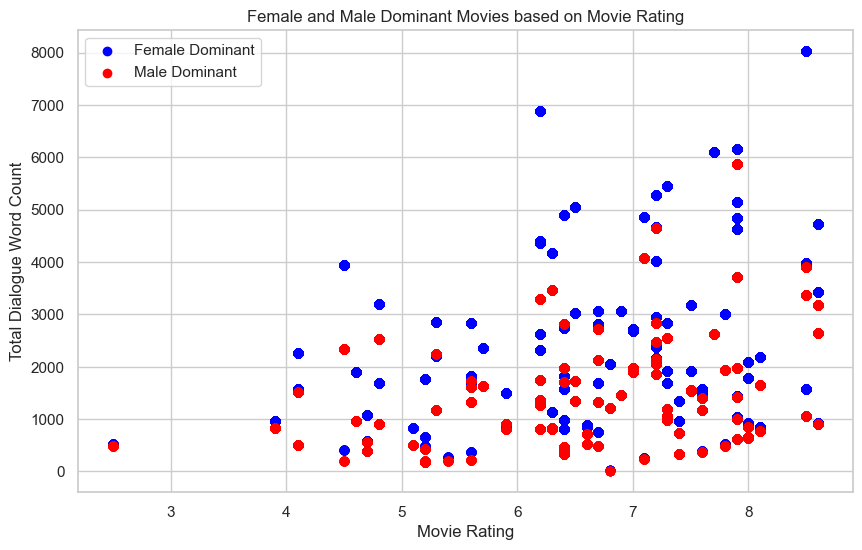

In [147]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting the graph
plt.figure(figsize=(10, 6))

# Scatter plot for female-dominant movies
plt.scatter(female_dominant_movies_details_df['movie_rating'], female_dominant_movies_details_df['F'], color='blue', label='Female Dominant')

# Scatter plot for male-dominant movies
plt.scatter(female_dominant_movies_details_df['movie_rating'], female_dominant_movies_details_df['M'], color='red', label='Male Dominant')

# Adding labels and title
plt.xlabel('Movie Rating')
plt.ylabel('Total Dialogue Word Count')
plt.title('Female and Male Dominant Movies based on Movie Rating')
plt.legend()

# Show the plot
plt.show()


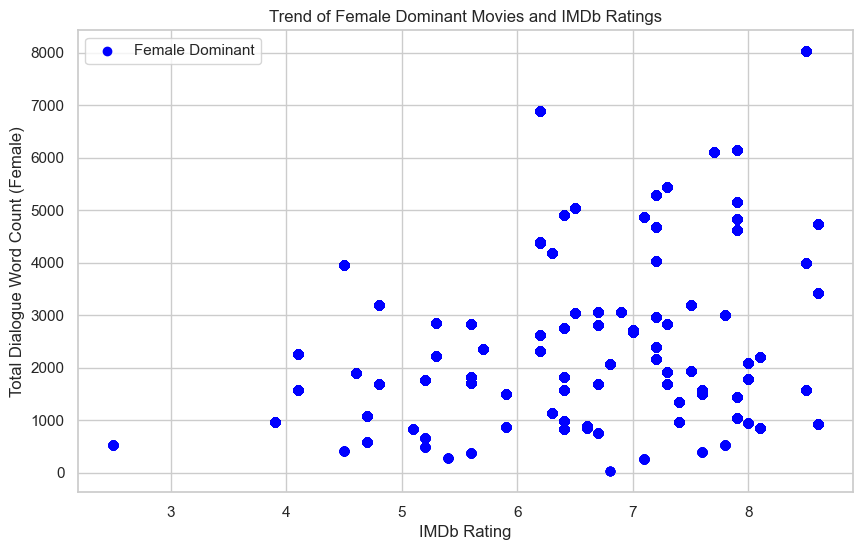

In [149]:
# Plotting the graph
plt.figure(figsize=(10, 6))

# Scatter plot for female-dominant movies and their ratings
plt.scatter(female_dominant_movies_details_df['movie_rating'], female_dominant_movies_details_df['F'], color='blue', label='Female Dominant')

# Adding labels and title
plt.xlabel('IMDb Rating')
plt.ylabel('Total Dialogue Word Count (Female)')
plt.title('Trend of Female Dominant Movies and IMDb Ratings')
plt.legend()

# Show the plot
plt.show()

In [152]:
subset_df = female_dominant_movies_details_df[['movie_id', 'F', 'M', 'movie_rating']].drop_duplicates()
subset_df.head()

,movie_id,F,M,movie_rating
0,m109,4836.0,1417.0,7.9
559,m114,920.0,908.0,8.6
738,m115,406.0,201.0,4.5
787,m117,2620.0,821.0,6.2
1148,m13,516.0,485.0,7.8


In [153]:
subset_df.shape

(91, 4)

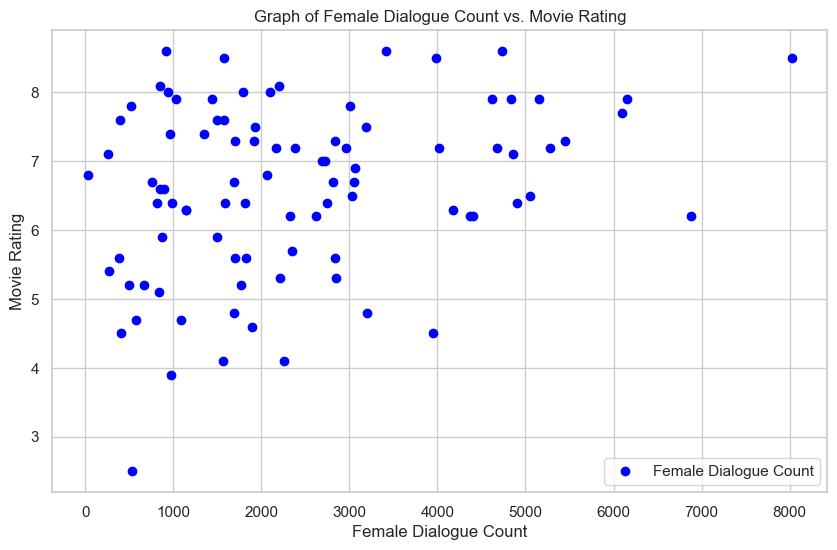

In [154]:

# Plotting the graph
plt.figure(figsize=(10, 6))

# Scatter plot for female dialogue count and movie rating
plt.scatter(subset_df['F'], subset_df['movie_rating'], color='blue', label='Female Dialogue Count')

# Adding labels and title
plt.xlabel('Female Dialogue Count')
plt.ylabel('Movie Rating')
plt.title('Graph of Female Dialogue Count vs. Movie Rating')
plt.legend()

# Show the plot
plt.show()

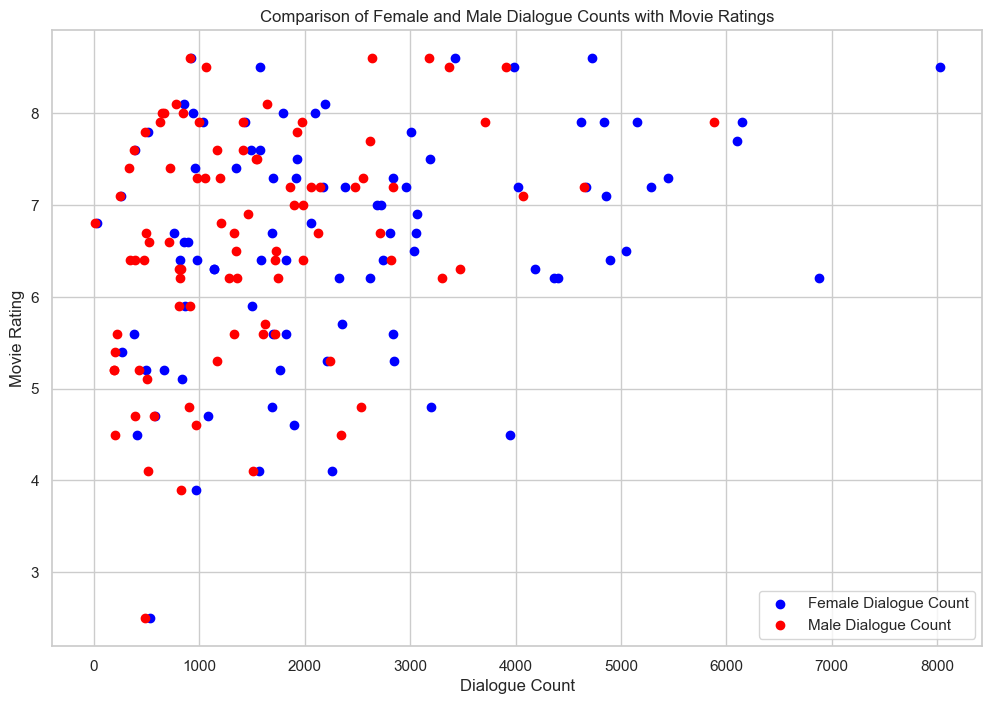

In [155]:
# Plotting the graph
plt.figure(figsize=(12, 8))

# Scatter plot for female and male dialogue counts with movie rating
plt.scatter(subset_df['F'], subset_df['movie_rating'], color='blue', label='Female Dialogue Count')
plt.scatter(subset_df['M'], subset_df['movie_rating'], color='red', label='Male Dialogue Count')

# Adding labels and title
plt.xlabel('Dialogue Count')
plt.ylabel('Movie Rating')
plt.title('Comparison of Female and Male Dialogue Counts with Movie Ratings')
plt.legend()

# Show the plot
plt.show()